In [2]:
pip install xgboost

     |████████████████████████████████| 686kB 2.3MB/s eta 0:00:01
  Stored in directory: /Users/sophiaperides/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Set up & handling the data
import os
os.chdir('/Users/sophiaperides/Desktop/Thinkful')
import csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action="ignore")

# Cleaning the data
import re

# Transforming the data
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import ensemble   # we'll use ensemble random forests


# Running the models
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# from sklearn.metrics import precision_score, recall_score, accuracy_score

#Statistics
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Introduction
Analyzing the IMDB Movie dataset, I'm going to look at if we can predict how successful a movie is using the adjusted revenue as the measure of success. With nearly 11,000 movies and twenty variables, I should be able to choose features correlated with the revenue to create a good model.

## Cleaning

There are 6,016 rows with an adjused revenue of $0. I'm going to remove these rows as

Columns homepage, director, cast, keywords, tagline, and production_companies are missing values. For the homepage column, I will assumme that a missing value indicates that a movie does not have a homepage. I'll create a dummy variable in which 0 indicates there is no homepage and 1 indicates that one exists. Only one movie is missing the director and five movies are missing the cast, so I will look up this information and manually add it to the dataset. I will set cells missing values for keywords, tagline, and production companies to 'Unknown'.

Off the bat, popularity, budget, revenue, runtime, and votecount have clear high outliers. I'm going to take a look at these columns and see if we can derive what may be going on. Cast, homepage, director, tagline, keywords, overview, genres, and production_companies are missing values. Nearly all of these contain categorical data so I will fill the values as best as I can and remove rows and/or columns I cannot.

In [3]:
movies = pd.read_csv('IMDBMovies.csv')
movies = pd.DataFrame(movies)
print(movies.columns)
print('\n', movies.describe())
movies.info()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

               id  popularity        budget        revenue   runtime  \
count  10866.000   10866.000     10866.000      10866.000 10866.000   
mean   66064.177       0.646  14625701.094   39823319.793   102.071   
std    92130.137       1.000  30913213.831  117003486.582    31.381   
min        5.000       0.000         0.000          0.000     0.000   
25%    10596.250       0.208         0.000          0.000    90.000   
50%    20669.000       0.384         0.000          0.000    99.000   
75%    75610.000       0.714  15000000.000   24000000.000   111.000   
max   417859.000      32.986 425000000.000 2781505847.000   900.000   

       vote_count  vote_ave

In [4]:
# pd.options.display.max_columns = None
movies[movies['revenue_adj'] == 0 ].shape
# pd.options.display.max_columns = None
# movies.head()
movies = movies[movies.revenue_adj != 0]
print(movies.describe())
movies.info()
movies.head()

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  
count    4850.000      4850.000      4850.000      4850.000       4850.000  
mean      436.216         6.149      2000.922  35161017.182  115077354.868  
std       806.416         0.799        11.569  43756717.053  198841916.046  
min        10.000         2.100      1960.000         0.000  

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000


## Genres Variable
The contents in the genres column contain multiple genres separated by the a symbol. I'm going to separate the genres in each cell, find all unique values, and create a dummy column for each genre. If a movie contains (?) that genre, the column will have the value one in the corresponding cell. Otherwise, the column for that movie will contain a zero.

In [5]:

# Create a list of the genres

Genres = movies.genres.unique()
genres = []
flatten_genres = []

for list_of_genres in Genres:
    movies_genres = list_of_genres.split('|')
    genres.append(movies_genres)
    for i in range(len(genres)): #Traversing through the main list
        for j in range (len(genres[i])): #Traversing through each sublist
            flatten_genres.append(genres[i][j]) #Appending elements into our flat_list

unique_genres = set(flatten_genres)
print(unique_genres)

# Creating dummy columns for each genre
for genre in unique_genres:
    movies[genre] = 0 

{'Animation', 'Adventure', 'TV Movie', 'Fantasy', 'Mystery', 'Crime', 'Western', 'Foreign', 'Drama', 'Thriller', 'Science Fiction', 'Family', 'Action', 'History', 'Documentary', 'Romance', 'Comedy', 'War', 'Music', 'Horror'}


In [6]:
# Populating each genre column
def populating_genres(df, genre_list):
    for i, row in df.iterrows():
        movies_genres = df.loc[i]['genres']
        for genre in genre_list:
            if genre in movies_genres:
                df.at[i, genre] = 1
    return df

populating_genres(movies, unique_genres)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,Science Fiction,Family,Action,History,Documentary,Romance,Comedy,War,Music,Horror
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,1,0,1,0,0,0,0,0,0,0
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,1,0,1,0,0,0,0,0,0,0
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,1,0,0,0,0,0,0,0,0,0
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,1,0,1,0,0,0,0,0,0,0
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,0,0,1,0,0,0,0,0,0,0
5,281957,tt1663202,9.111,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro González Iñárritu,"(n. One who has returned, as if from the dead.)",...,0,0,0,0,0,0,0,0,0,0
6,87101,tt1340138,8.654,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,...,1,0,1,0,0,0,0,0,0,0
7,286217,tt3659388,7.667,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,...,1,0,0,0,0,0,0,0,0,0
8,211672,tt2293640,7.404,74000000,1156730962,Minions,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,http://www.minionsmovie.com/,Kyle Balda|Pierre Coffin,"Before Gru, they had a history of bad bosses",...,0,1,0,0,0,0,1,0,0,0
9,150540,tt2096673,6.327,175000000,853708609,Inside Out,Amy Poehler|Phyllis Smith|Richard Kind|Bill Ha...,http://movies.disney.com/inside-out,Pete Docter,Meet the little voices inside your head.,...,0,1,0,0,0,0,1,0,0,0


## Cast Variable

Each cell in the cast column has up to the five central actors and/or actresses in the movie. I have found a list of the top 100 movie stars from 1960, the year of the oldest movie, and to make use of this variable, I will create a new feature called 'top_100_actors' which holds the number of actors each movie has from this list. We would expect to see that movies with any/more stars than others would be more successful.

The list I used had replaced many letters containing accents (ex. á, å, etc.) with incorrect characters, so I used a list comprehension to filter these names and updated them directly in the csv.

In [7]:
# Adding the missing top five cast members
movies[movies['cast'].isnull()]
movies.at[1088, 'cast'] = 'Vivian Maier|John Maloof|Daniel Arnaud|Simone Amédé|Maren Baylaender'
movies.at[4127, 'cast'] = 'Belladonna|Marlon Brando|Elton John|Julia Louis-Dreyfus|Madonna'
movies.at[4889, 'cast'] = 'Jay Bastian|Joe Biden|Cait Brasel|Gene Burris Jr.|Dinesh D\'Souza'
movies.at[7813, 'cast'] = 'Dylan Avery|Mahmoud Ahmad|Ahmed Al-Ghamdi|Hamza Al-Ghamdi|Saeed Al-Ghamdi'
movies.at[9564, 'cast'] = 'Christie Brinkley|David Brinkley|Pope John Paul II|Dan Rather|Cheryl Tiegs'
movies[movies['cast'].isnull()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,Science Fiction,Family,Action,History,Documentary,Romance,Comedy,War,Music,Horror


In [8]:
# Splitting the cast information into lists
movies['cast'] = movies['cast'].apply(lambda x: x.split('|'))

In [9]:
## Create a list of actors

Cast = movies.cast # a list of the list of cast members in each movie
cast = [] # 
flatten_cast = []

for list_of_actors in Cast: 
    cast.append(list_of_actors)
    for i in range(len(cast)): #Traversing through the main list
        for j in range (len(cast[i])): #Traversing through each sublist
            flatten_cast.append(cast[i][j]) #Appending elements into our flat_list

unique_actors = set(flatten_cast)


In [10]:
# cleaning names - finding actor's names with non-alphanumeric characters
unique_actors = list(unique_actors)
print(type(unique_actors)) 
non_alphanumeric = [i for i in unique_actors if not i.lower().replace(" ", "").replace('\'', '').replace('.', '')
                    .replace('-', '').replace(',','').replace('ÃƒÂ¥', 'å').replace('ÃƒÂ¡', 'á').replace('ÃƒÂ\xad', 'í')
                    .isalpha()]
print('\n \n Names with non-alphanumeric characters:\n ', non_alphanumeric)

<class 'list'>

 
 Names with non-alphanumeric characters:
  ['āềâ€” Thềâ€¹ HÃ¡ÂºÂ£i YÃ¡ÂºÂ¿n', 'Jordi MollÃƒÂ\xa0', '50 Cent', 'Antonio SabÃƒÂ\xa0to, Jr.', 'JōÂ«rōta Kosugi', 'Linh āan PhÃ¡ÂºÂ¡m', 'Ã\xa0Â¸ÂªÃ\xa0Â¸Â£Ã\xa0Â¸Å¾Ã\xa0Â¸â€¡Ã\xa0Â¸Â©Ã\xa0Â¹Å’ Ã\xa0Â¸Å\xa0Ã\xa0Â¸Â²Ã\xa0Â¸â€¢Ã\xa0Â¸Â£Ã\xa0Â¸Âµ']


In [11]:
# Importing the top 100 stars and removing 'Actor' and 'Actress' so we just have names in the stars dataframe

top_100_actors = pd.read_csv('top_100_stars.csv')
top_100_actors = pd.DataFrame(top_100_actors)


top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actor', '')
top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actress', '')

# Converting the series to a list so we can compare it to the cast lists
top_100_actors = top_100_actors['Name'].tolist()
top_100_actors[:5]

movies['top_100_actors'] = [len(set(i) & set(top_100_actors)) for i in movies['cast']]
print('Number of movies for each number of stars (0-5): \n', movies.top_100_actors.value_counts())

Number of movies for each number of stars (0-5): 
 0    4022
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64


## Tagline Variable
For this variable, I will create a new column called 'tagline_length' for the number of words in the tagline to see if there is any correlation between tagline length and revenue. My hypothesis is that movies with shorter taglines fare better - short and sweet is key!

In [12]:
movies['tagline_length'] = movies['tagline'].str.count(' ') + 1
movies.tagline_length.fillna(0 , inplace=True)

## Homepage Variable
I will create a dummy variable that reflects whether or not a movie has a homepage. This column will contain a one if a movie has a homepage and a zero if it does not.

In [13]:
movies['homepage_dummy'] = movies['homepage'].apply(lambda x: 0 if pd.isnull(x) else 1)

## Production Companies Variable
I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [14]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies['production_companies'].unique()), 'production companies.')

There are 3683 production companies.


## Keywords Variable
I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [15]:
movies['keywords'] = movies['keywords'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies[movies['keywords'] == 'Unknown']), 'movies with no keywords.')

There are 235 movies with no keywords.


## Director Variable
One movie is missing its director, so I will manually add it.

In [16]:
movies.director.isnull()
movies.at[1088, 'director'] = 'Aziz Mirza'
print('There are', len(movies.director.unique()), 'unique directors.')

There are 2134 unique directors.


## Correlation Matrix
Our first look at the correlation matrix provides some insight into the relationships between the variables and our arget, the adjusted revenue. There are strong relationships between budget and popularity which is intuitive, but there's quite a strong correlation between vote count, stronger even than the average vote which is interesting. Vote count and popularity (the average number of visits the IMDB page receives per week) are strongly correlated so I'm going to combine them into a single feature. Family and Animation genres have a fairly strong correlation at 0.516, so I'll combine them as well.

The features I'll start with are vc_pop (the combination of vote_count and popularity), budget_adj, runtime, vote_average, number_of_stars, and Adventure.

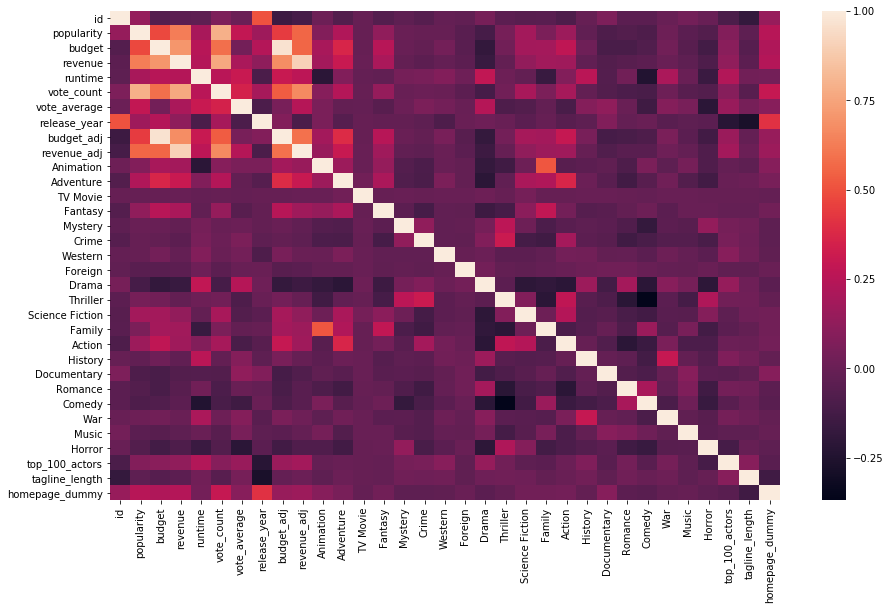

In [17]:
plt.figure(figsize=(15,9))
sns.heatmap(movies.corr())

In [18]:
movies.corr()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,...,History,Documentary,Romance,Comedy,War,Music,Horror,top_100_actors,tagline_length,homepage_dummy
id,1.000,0.140,-0.068,-0.041,-0.031,0.070,0.008,0.507,-0.146,-0.115,...,-0.007,0.067,-0.042,-0.045,0.001,0.035,-0.001,-0.099,-0.176,0.148
popularity,0.140,1.000,0.481,0.629,0.201,0.788,0.289,0.170,0.440,0.562,...,-0.020,-0.086,-0.072,-0.085,0.012,-0.044,-0.073,0.083,-0.036,0.248
budget,-0.068,0.481,1.000,0.704,0.247,0.586,0.037,0.238,0.964,0.561,...,0.021,-0.101,-0.102,-0.078,0.030,-0.053,-0.127,0.108,-0.058,0.223
revenue,-0.041,0.629,0.704,1.000,0.238,0.764,0.207,0.121,0.674,0.905,...,-0.022,-0.071,-0.057,-0.041,0.005,-0.033,-0.090,0.126,-0.037,0.237
runtime,-0.031,0.201,0.247,0.238,1.000,0.252,0.308,-0.100,0.304,0.264,...,0.259,-0.067,0.028,-0.243,0.212,0.005,-0.156,0.234,0.031,0.035
vote_count,0.070,0.788,0.586,0.764,0.252,1.000,0.351,0.197,0.533,0.667,...,-0.017,-0.069,-0.091,-0.105,0.014,-0.053,-0.072,0.094,-0.055,0.297
vote_average,0.008,0.289,0.037,0.207,0.308,0.351,1.000,-0.095,0.049,0.242,...,0.087,0.129,0.004,-0.138,0.088,0.052,-0.210,0.151,0.047,0.100
release_year,0.507,0.170,0.238,0.121,-0.100,0.197,-0.095,1.000,0.083,-0.100,...,-0.036,0.076,-0.011,0.003,-0.047,-0.036,-0.044,-0.220,-0.274,0.410
budget_adj,-0.146,0.440,0.964,0.674,0.304,0.533,0.049,0.083,1.000,0.593,...,0.053,-0.112,-0.101,-0.089,0.057,-0.043,-0.132,0.158,-0.015,0.149
revenue_adj,-0.115,0.562,0.561,0.905,0.264,0.667,0.242,-0.100,0.593,1.000,...,-0.009,-0.076,-0.050,-0.048,0.020,-0.013,-0.081,0.187,0.011,0.165


## Visualizing the relationships between variables and the target¶

The graphs below give a nice visual of variables with the highest correlations of the target. While it's interesting that there's a higher correlation between vote_count and popularity than vote_average and popularity, I imagine this is a case of 'any press is good press' - more individuals voting on a movie indicates that more individuals have seen and spent money on the movie.

Unsurprisingly, movies with a higher adjusted budjet tend to have higher adjusted revenue. It stands to reason that the higher a movie's budget, the more opportunies and the higher the quality (production, cast, etc.) the movie can have.

Finally, we can see there's a slight increase in the adjusted revenue as the number of actors in the top_100_actors list increases.

<Figure size 144x216 with 0 Axes>

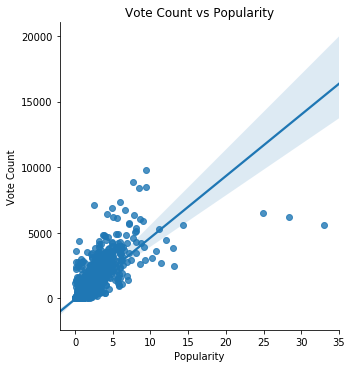

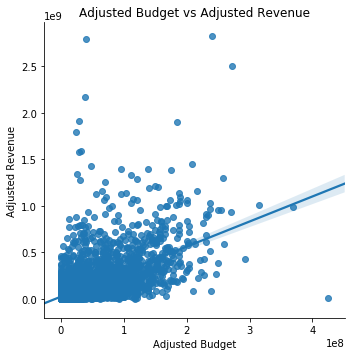

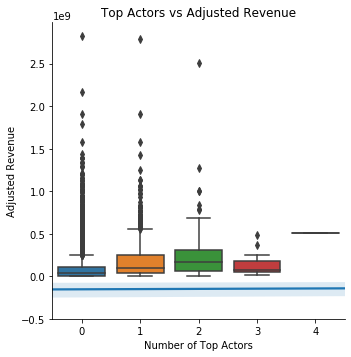

In [19]:
plt.figure(figsize=(2,3))
sns.lmplot(x='popularity', y='vote_count', data=movies)
plt.title('Vote Count vs Popularity')
plt.xlabel('Popularity')
plt.ylabel('Vote Count')


sns.lmplot(x='budget_adj', y='revenue_adj', data=movies)
plt.title('Adjusted Budget vs Adjusted Revenue')
plt.xlabel('Adjusted Budget')
plt.ylabel('Adjusted Revenue')

sns.lmplot(x='runtime', y='revenue_adj', data=movies)
plt.title('Runtime vs Adjusted Revenue')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Adjusted Revenue')

sns.boxplot(x='top_100_actors', y='revenue_adj', data=movies)
plt.title('Top Actors vs Adjusted Revenue')
plt.xlabel('Number of Top Actors')
plt.ylabel('Adjusted Revenue')
plt.show()

In [20]:
movies['vc_pop'] = movies['vote_count'] * movies['popularity']
corr_mat = movies.corr().loc[:, ["revenue_adj"]].sort_values(by='revenue_adj', ascending=False)
corr_mat

,revenue_adj
revenue_adj,1.000
revenue,0.905
vote_count,0.667
budget_adj,0.593
popularity,0.562
budget,0.561
vc_pop,0.478
Adventure,0.305
runtime,0.264
vote_average,0.242


## Testing for Outliers and Normality
The Jarque Bera and Normality tests produce p-values of or extremely close to zero. However, when I plot the features it is clear that they are not normal and have outliers. How/why is this possible?

A note on outliers: the extreme values in vc_pop seem to be legitimate - neither the vote_count nor the popularity appear to be errors budget_adj - legit, did the research for the top couple movies

In [21]:
# Testing for Normality
features_to_test = features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors', 'tagline_length']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))


Testing for normality on revenue_adj:
Jarque-Bera test statistics for revenue_adj is 226940.3455244923 and p value is 0.0
Normality test statistics for revenue_adj is 4522.292435228974 and p value is 0.0

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27345131.383749064 and p value is 0.0
Normality test statistics for vc_pop is 9645.87772348386 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 10959.419887756596 and p value is 0.0
Normality test statistics for budget_adj is 2133.926912739724 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 3797640.9538830956 and p value is 0.0
Normality test statistics for runtime is 5921.175938826389 and p value is 0.0

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 112.99050060716442 and p value is 0.0
Normality test statistics for vote_average is 102.28513371965839 and p value is 6.1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for revenue_adj feature. 







'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


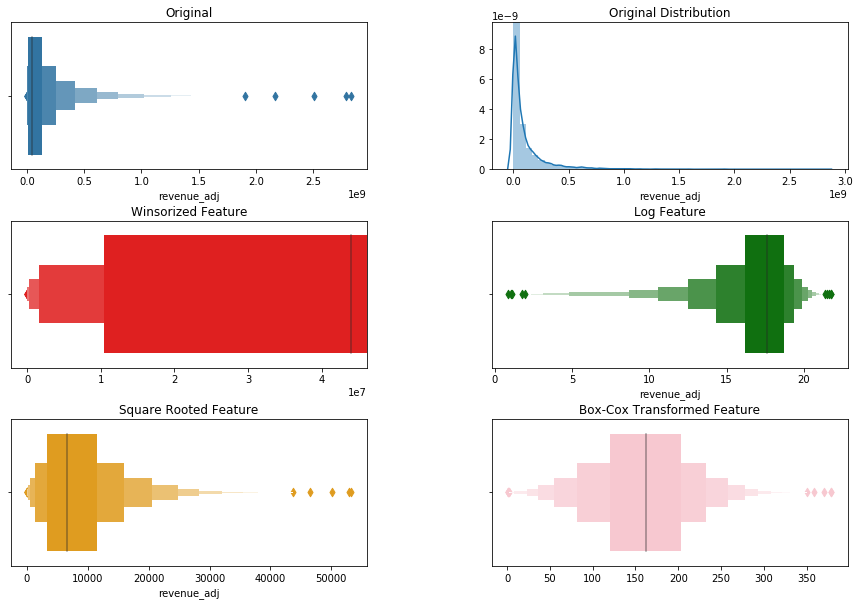

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for vc_pop feature. 







'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


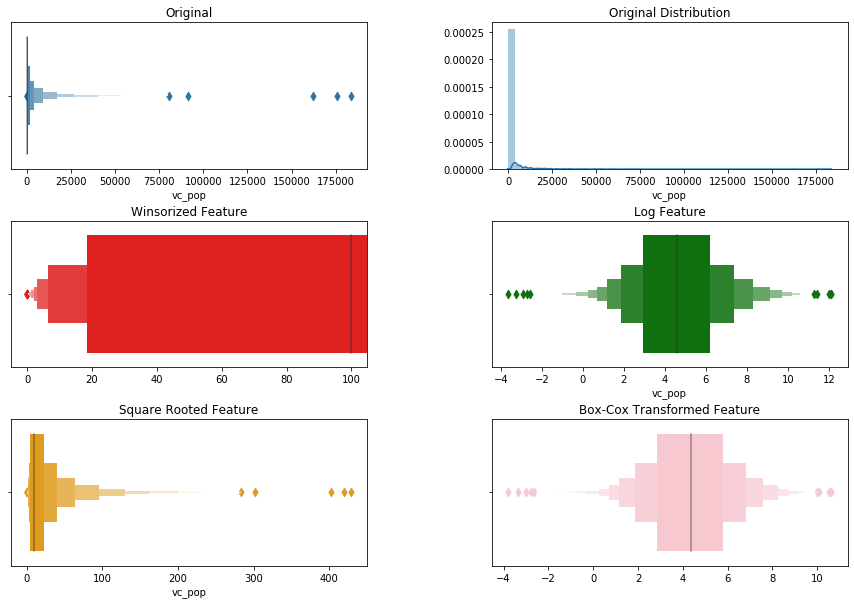

budget_adj Data isn't positive.

 Outlier Visualization for budget_adj feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


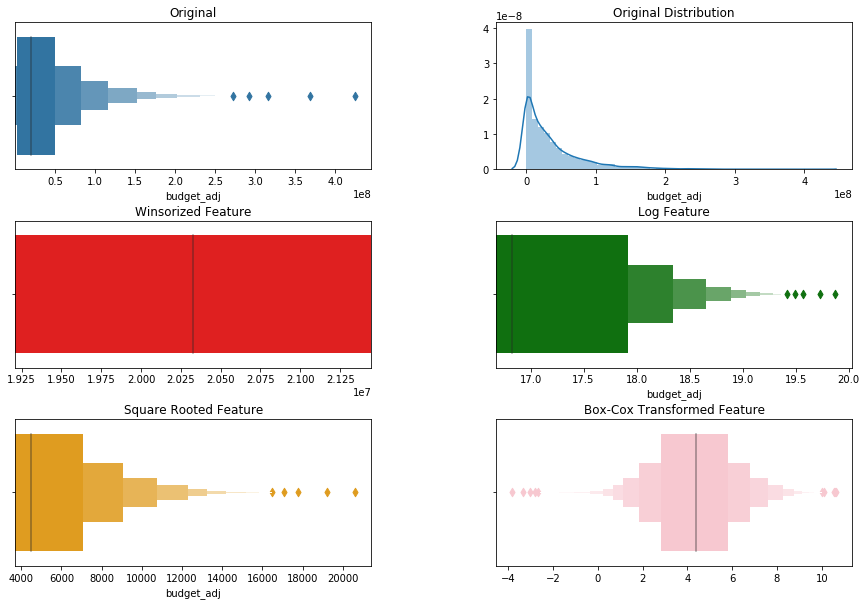

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for runtime feature. 







'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


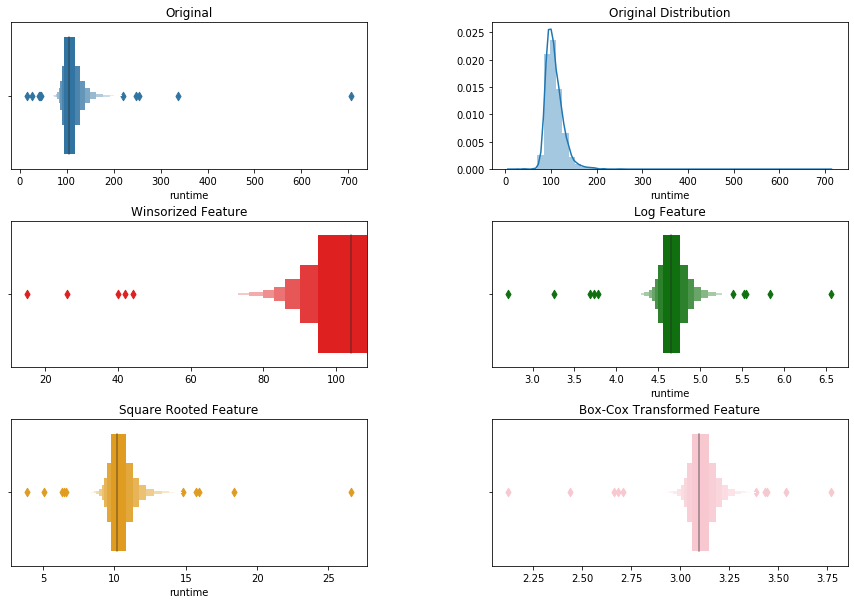

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for vote_average feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


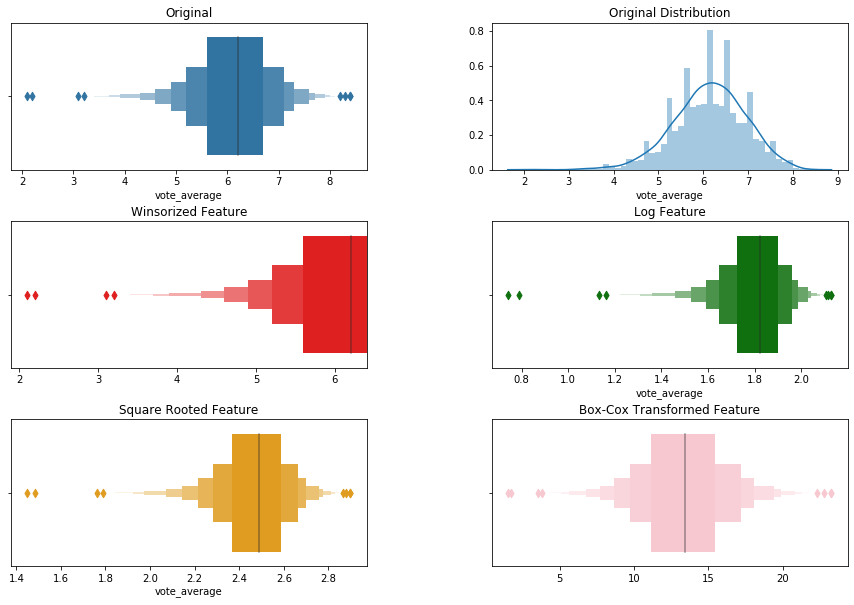

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

top_100_actors Data isn't positive.

 Outlier Visualization for top_100_actors feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


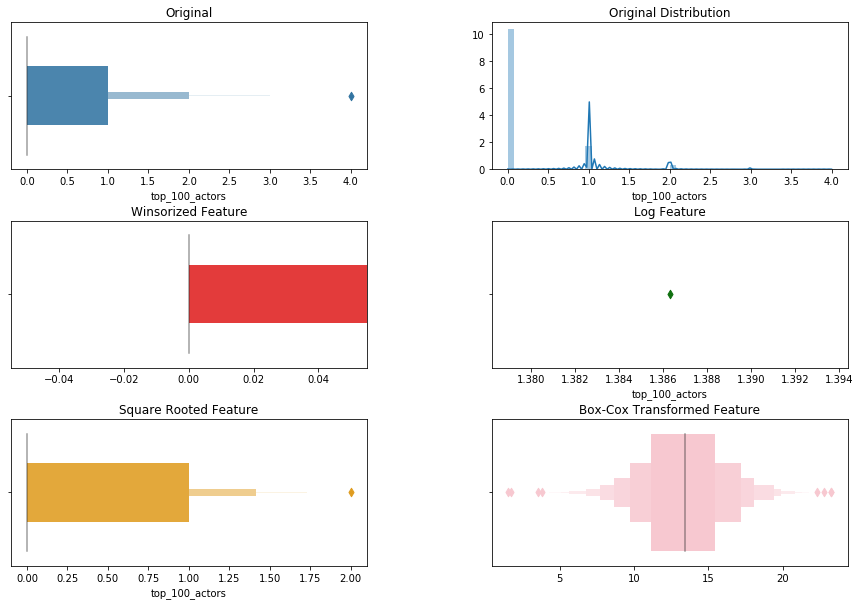

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


tagline_length Data isn't positive.

 Outlier Visualization for tagline_length feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


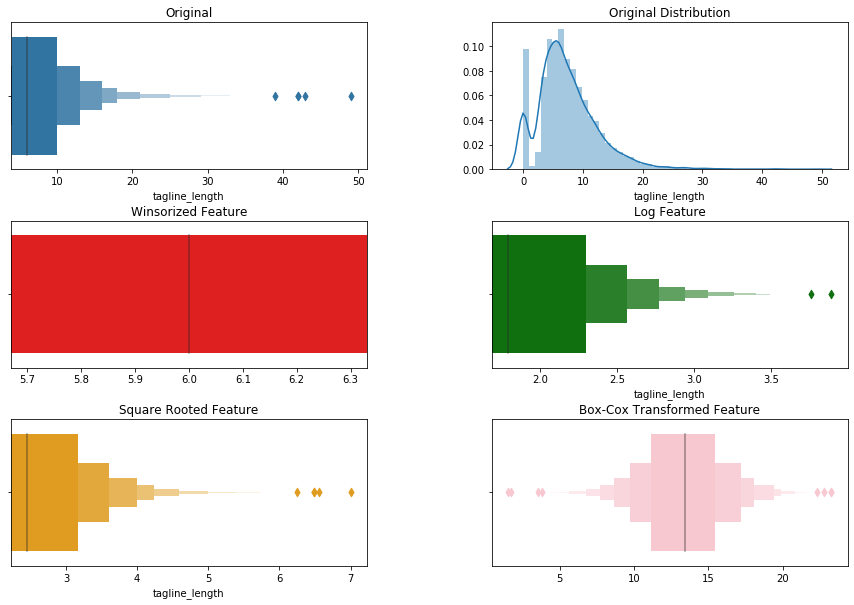

In [22]:
# Specify a list with features I want to test for normality. 
# Visuals for outliers and normality
for feat in features_to_test:
    winsorized_feature = winsorize(movies[feat], (0, 0.10))
    log_feature = np.log(movies[feat])
    sqrt_feature = np.sqrt(movies[feat])
    try:
        bc_feature,_ = stats.boxcox(movies[feat])
    except ValueError: 
        print(feat, 'Data isn\'t positive.')
    
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.subplot(3, 2, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Original')
    print('\n')
    plt.subplot(3, 2, 2)
    sns.distplot(movies[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.subplot(3, 2, 3)
    sns.boxenplot(winsorized_feature, color='red')
    plt.title('Winsorized Feature')
    plt.subplot(3, 2, 4)
    sns.boxenplot(log_feature, color='green')
    plt.title('Log Feature')
    print('\n')
    plt.subplot(3, 2, 5)
    sns.boxenplot(sqrt_feature, color='orange')
    plt.title('Square Rooted Feature')
    plt.subplot(3, 2, 6)
    sns.boxenplot(bc_feature, color='pink')
    plt.title('Box-Cox Transformed Feature')
    plt.subplots_adjust(hspace=0.35, wspace=0.35)
    plt.show()

## Update Variable Values
As I was visualizing the data, there were a few values that warranted further investigation, so I have updated them here.

In [23]:
# The budget_adj for The Warrior's way appears to have an extra 0 - multiple sources have the budget at $42 million
movies.loc[2244, 'budget_adj'] = 42500000
# Band of Brothers and Carlos are miniseries which accounts for their lengthy runtimes.
# We're only interested in movies, so I'll remove them from the dataset.
movies = movies[movies.runtime < 338]

movies.sort_values(by='vote_average', ascending=False).head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,Documentary,Romance,Comedy,War,Music,Horror,top_100_actors,tagline_length,homepage_dummy,vc_pop
4178,278,tt0111161,7.192,25000000,28341469,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",NaN,Frank Darabont,Fear can hold you prisoner. Hope can set you f...,...,0,0,0,0,0,0,1,10.000,0,41382.992
7948,24128,tt0088178,0.283,1200000,4978922,Stop Making Sense,"[David Byrne, Tina Weymouth, Chris Frantz, Jer...",NaN,Jonathan Demme,Why stop making sense? Why a movie? Why a big ...,...,1,0,0,0,1,0,0,24.000,0,6.513


## Normalizing the Features for Linear Regression Models

The values of the t-tests confirm the new features are closer to normal.

In [24]:
movies["norm_winsorized_revenue_adj"] = normalize(np.array(winsorize(movies['revenue_adj'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vc_pop"] = normalize(np.array(winsorize(movies['vc_pop'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_budget_adj"] = normalize(np.array(np.sqrt(movies['budget_adj'])).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_runtime"] = normalize(np.array(winsorize(movies['runtime'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vote_average"] = normalize(np.array(winsorize(movies['vote_average'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_100_actors"] = normalize(np.array(winsorize(movies['top_100_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_tagline_length"] = normalize(np.array(np.sqrt(movies['tagline_length'])).reshape(1,-1)).reshape(-1,1)

In [25]:
# Testing for Normality
features_to_test = ['norm_winsorized_revenue_adj', 'norm_winsorized_vc_pop', 'norm_sqrt_budget_adj',
                    'norm_winsorized_runtime', 'norm_winsorized_vote_average', 'norm_winsorized_100_actors', 'norm_sqrt_tagline_length']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_revenue_adj:
Jarque-Bera test statistics for norm_winsorized_revenue_adj is 1123.713683320344 and p value is 0.0
Normality test statistics for norm_winsorized_revenue_adj is 732.9389443861746 and p value is 6.987638685634258e-160

Testing for normality on norm_winsorized_vc_pop:
Jarque-Bera test statistics for norm_winsorized_vc_pop is 2551.702011152204 and p value is 0.0
Normality test statistics for norm_winsorized_vc_pop is 1282.439565295033 and p value is 3.3249621740659162e-279

Testing for normality on norm_sqrt_budget_adj:
Jarque-Bera test statistics for norm_sqrt_budget_adj is 1728.914503062292 and p value is 0.0
Normality test statistics for norm_sqrt_budget_adj is 983.0805191253575 and p value is 3.36339317546824e-214

Testing for normality on norm_winsorized_runtime:
Jarque-Bera test statistics for norm_winsorized_runtime is 22.180198123233662 and p value is 1.5262693177309217e-05
Normality test statistics for norm_winsorized_runtime 

In [26]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)

,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.761
budget_adj,0.658
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.583
popularity,0.498
vc_pop,0.327
runtime,0.301


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for norm_winsorized_revenue_adj feature. 



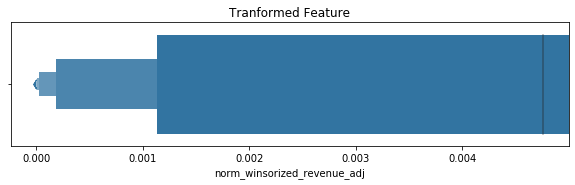

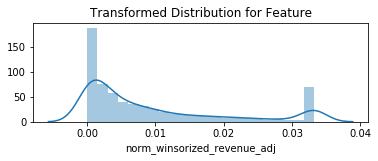

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_vc_pop feature. 



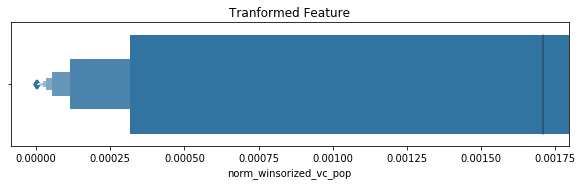

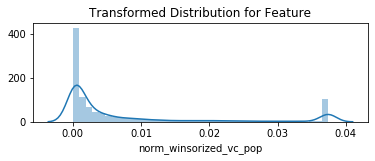

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_sqrt_budget_adj feature. 



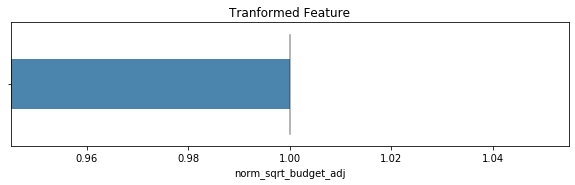

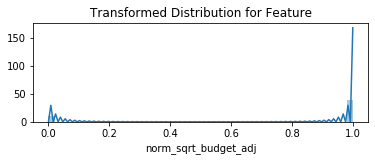

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_runtime feature. 



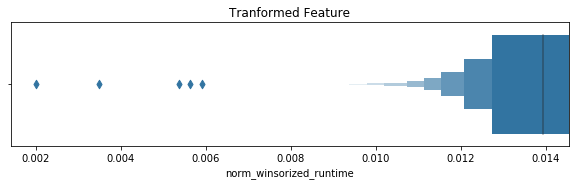

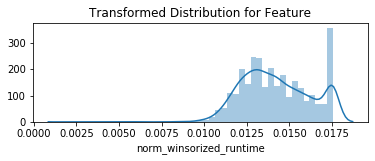

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_vote_average feature. 



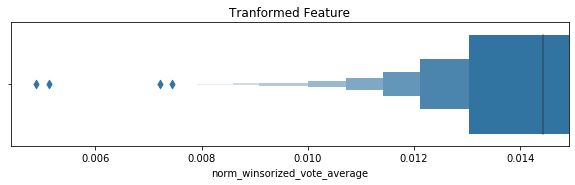

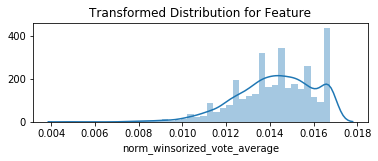

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_100_actors feature. 



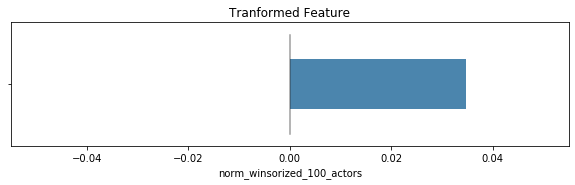

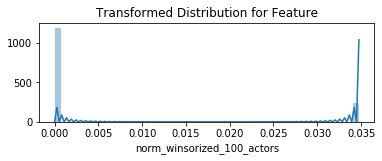




 Outlier Visualization for norm_sqrt_tagline_length feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


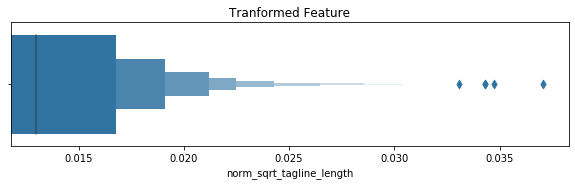

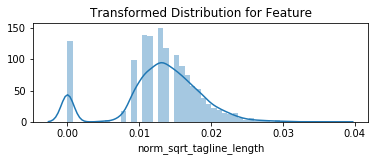

In [27]:
transformed_features = ['norm_winsorized_revenue_adj', 'norm_winsorized_vc_pop', 'norm_sqrt_budget_adj',
                    'norm_winsorized_runtime', 'norm_winsorized_vote_average', 'norm_winsorized_100_actors', 
                    'norm_sqrt_tagline_length']

for feat in transformed_features:
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (10, 5))
    plt.subplot(2, 1, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Tranformed Feature')
    plt.show()
    print('\n')
    plt.subplot(2, 1, 2)
    sns.distplot(movies[feat])
    plt.title('Transformed Distribution for Feature')
    plt.show()
    print('\n')
    
   

## The Cleaned and Transformed Data

A look at the data after it's been cleaned and transformed.

In [28]:
print(movies.describe())

              id  popularity        budget        revenue  runtime  \
count   4848.000    4848.000      4848.000       4848.000 4848.000   
mean   44516.111       1.045  29578186.482   89231501.979  107.794   
std    72259.109       1.357  40519224.943  162096040.407   19.012   
min        5.000       0.001         0.000          2.000   15.000   
25%     8283.500       0.388   1700000.000    7724243.750   95.000   
50%    12153.500       0.681  15000000.000   31826540.000  104.000   
75%    43951.500       1.211  40000000.000   99823196.750  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  254.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  \
count    4848.000      4848.000      4848.000      4848.000       4848.000   
mean      436.324         6.148      2000.920  35092911.166  115092896.827   
std       806.560         0.799        11.571  43402495.810  198875386.412   
min        10.000         2.100      1960.000         0.0

# Running the Models
All cross validation models will be run with ten folds, and all models using training and testing sets will use a 70%/30% split unless otherwise specified. Each round of models will test a new set of features.

## The First Round
For our first run, I'll use all features that have correlations of greater than 0.2 with the target variable, revenue_adj. I'll use the transformed variables for the linear regression model (OLS, Ridge, Lasso, and ElasticNet) and the original variables for the others (Random Forests, SVM, Gradient Boosting, and XGBoost).

In [29]:
linear_features1 = movies[['norm_winsorized_vc_pop', 'norm_sqrt_budget_adj', 'norm_winsorized_runtime',
                           'Adventure', 'norm_winsorized_100_actors', 'norm_winsorized_vote_average']]
linear_target1 = movies['norm_winsorized_revenue_adj']
linear_X1_train, linear_X1_test, linear_Y1_train, linear_Y1_test = train_test_split(linear_features1, linear_target1,
                test_size = .3, random_state = 465)
linear_X1_train_const = sm.add_constant(linear_X1_train)
linear_X1_test_const = sm.add_constant(linear_X1_test)

features1 = movies[['vc_pop', 'budget_adj', 'runtime','Adventure', 'top_100_actors', 'vote_average']]
target1 = movies['revenue_adj']
X1_train, X1_test, Y1_train, Y1_test = train_test_split(features1, target1, test_size = .3, random_state = 465)


## OLS with Training & Testing Sets

This model gives R-squared/adjusted values of 0.485 for the training set and 0.477 for the testing set. All of our evaluation metrics are fairly low - in particular, the mean squared error is 0.0006 which is much lower than the Random Forests model.

In [30]:
print("The number of observations in training set is {}".format(linear_X1_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X1_test.shape[0]))

# We fit an OLS model using sklearn

ols = LinearRegression().fit(linear_X1_train_const, linear_Y1_train)

results_train = sm.OLS(linear_Y1_train, linear_X1_train_const).fit()
results_test = sm.OLS(linear_Y1_test, linear_X1_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y1_preds_train = ols.predict(linear_X1_train_const)
Y1_preds_test = ols.predict(linear_X1_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(linear_X1_train_const, linear_Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(linear_X1_test_const, linear_Y1_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y1_test - Y1_preds_test) / linear_Y1_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.485
Model:                                     OLS   Adj. R-squared:                  0.485
Method:                          Least Squares   F-statistic:                     532.4
Date:                         Sun, 15 Dec 2019   Prob (F-statistic):               0.00
Time:                                 15:46:26   Log-Likelihood:                 11685.
No. Observations:                         3393   AIC:                        -2.336e+04
Df Residuals:                             3386   BIC:                        -2.331e+04
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation
The OLS model results in a range of 0.221 to 0.604 for R-squared scores in cross validation with an average of 0.47, clearly performing more poorly compared to the Random Forests model.

In [31]:
cross_val_scores = cross_val_score(LinearRegression(), linear_features1, linear_target1, cv=10)
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n OLS R-Squared Score: ', cross_val_scores.mean())

nmse_cross_val_scores = cross_val_score(LinearRegression(), linear_features1, linear_target1, cv=10, scoring='neg_mean_squared_error')
print('OLS Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

R-Squared Scores with Cross Validation:  [0.38952731 0.56406285 0.60447329 0.58389684 0.5080228  0.56297623
 0.54568735 0.35399892 0.35192628 0.22179614]

 OLS R-Squared Score:  0.4686368016440481
OLS Negative MSE Score:  -6.224573361635791e-05
Negative MSE Scores with Cross Validation:  [-8.19907484e-05 -5.05335419e-05 -4.40951275e-05 -5.05213809e-05
 -5.92912301e-05 -3.77650895e-05 -4.89803768e-05 -7.54744231e-05
 -7.14307566e-05 -1.02374661e-04]


## Lasso Regression Model

The Lasso model with training sets is the worst model we've seen so far with R-squareds of essentially 0 for both the training and testing sets, indicating it is no better than simply not having a model. I will likely proceed without this model.

In [32]:
print("The number of observations in training set is {}".format(linear_X1_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X1_test.shape[0]))
print('\n')

lassoregr = Lasso(alpha=0.001)
 
lassoregr.fit(linear_X1_train, linear_Y1_train)

# We are making predictions here
Y1_preds_train = lassoregr.predict(linear_X1_train)
Y1_preds_test = lassoregr.predict(linear_X1_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(linear_X1_train, linear_Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(linear_X1_test, linear_Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y1_test - Y1_preds_test) / linear_Y1_test)) * 100))


The number of observations in training set is 3393
The number of observations in test set is 1455


R-squared of the model on the training set is: 0.049566095517838415
-----Test set statistics-----
R-squared of the model on the test set is: 0.05000948643043068
Mean absolute error of the prediction is: 0.008525122657199876
Mean squared error of the prediction is: 0.00011203733678822792
Root mean squared error of the prediction is: 0.010584769094705274
Mean absolute percentage error of the prediction is: 3875291.8254429367


## Lasso Regression Model with Cross Validation

The Lasso performs much better with cross validation resulting in an R-squared of 0.48 for the model.

In [33]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(n_alphas=5)
lassoregrCV.fit(linear_features1, linear_target1)

# We are making predictions here
Y1_preds = lassoregrCV.predict(linear_features1)


print('Lasso Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(lassoregrCV.score(linear_features1, linear_target1)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target1, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target1, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target1, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target1 - Y1_preds) / linear_target1)) * 100))


Lasso Regression with Cross Validation:
Lasso Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.47900907929065145
Mean absolute error of the prediction is: 0.00571078045138019
Mean squared error of the prediction is: 6.077158757323272e-05
Root mean squared error of the prediction is: 0.007795613354523986
Mean absolute percentage error of the prediction is: 2801708.1751329056


Using GridSearchCV to find the best parameters for the Lasso Model.

In [34]:
lasso_gsc = GridSearchCV(
        estimator=LassoCV(),
        param_grid={
            'eps': [0.001, 0.001, 0.1, 1]},
#             'n_alphas': [0, 1, 10]},
        cv=10, scoring='r2', verbose=1, n_jobs=-1)

grid_result = lasso_gsc.fit(linear_features1, linear_target1)
best_params = grid_result.best_params_
# svr_gsc.best_estimator_
best_lasso = LassoCV(eps=best_params['eps'], verbose=False)
# n_alphas=best_params['n_alphas'],
print('Parameters for the best Lasso model: ', best_lasso)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Parameters for the best Lasso model:  LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.2s finished


In [35]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

lassoregrCV.fit(linear_features1, linear_target1)

# We are making predictions here
Y1_preds = lassoregrCV.predict(linear_features1)


print('Lasso Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(lassoregrCV.score(linear_features1, linear_target1)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target1, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target1, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target1, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target1 - Y1_preds) / linear_target1)) * 100))

Lasso Regression with Cross Validation:
Lasso Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.47900907929065145
Mean absolute error of the prediction is: 0.00571078045138019
Mean squared error of the prediction is: 6.077158757323272e-05
Root mean squared error of the prediction is: 0.007795613354523986
Mean absolute percentage error of the prediction is: 2801708.1751329056


## Ridge Regression with Training & Testing Sets
The Ridge model performs similarly to the OLS model with an R-squared of 0.475 on the test set, so I will continue to test with it as we change our features.

In [36]:
ridgeregr = Ridge(alpha=0) 
ridgeregr.fit(linear_X1_train, linear_Y1_train)

# We are making predictions here
Y1_preds_train = ridgeregr.predict(linear_X1_train)
Y1_preds_test = ridgeregr.predict(linear_X1_test)

print('Ridge Testing & Training Sets Outcomes:')
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(linear_X1_train, linear_Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(linear_X1_test, linear_Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(linear_Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y1_test - Y1_preds_test) / linear_Y1_test)) * 100))

Ridge Testing & Training Sets Outcomes:
R-squared of the model on the training set is: 0.48542060230888595
-----Test set statistics-----
R-squared of the model on the test set is: 0.47553906299642196
Mean absolute error of the prediction is: 0.00562183298919023
Mean squared error of the prediction is: 6.185241409469762e-05
Root mean squared error of the prediction is: 0.007864630575856544
Mean absolute percentage error of the prediction is: 1377244.2541054506


## Ridge Regression with Cross Validation
There is not much of a difference between the Ridge with training sets and the Ridge with cross validation, confirming it's a decent model.

In [37]:
ridgeCV = RidgeCV(alphas=(0.001, 0.01, .1, 1, 10), cv=10)
ridgeCV.fit(linear_features1, linear_target1)

# We are making predictions here
Y1_preds = ridgeCV.predict(linear_features1)

print('Ridge Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(ridgeCV.score(linear_features1, linear_target1)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target1, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target1, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target1, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target1 - Y1_preds) / linear_target1)) * 100))

Ridge Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.48272862247696935
Mean absolute error of the prediction is: 0.0056635559348422754
Mean squared error of the prediction is: 6.0337717163030617e-05
Root mean squared error of the prediction is: 0.007767735652236797
Mean absolute percentage error of the prediction is: 2432716.7576016965


## ElasticNet Regression Model with Training & Testing Sets

The ElasticNet performs virtually exactly the same as the Ridge model.

In [38]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(linear_X1_train, linear_Y1_train)

# We are making predictions here
Y1_preds_train = elasticregr.predict(linear_X1_train)
Y1_preds_test = elasticregr.predict(linear_X1_test)

print('ElasticNet Training & Testing Sets Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregr.score(linear_X1_train, linear_Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(linear_X1_test, linear_Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y1_test - Y1_preds_test) / linear_Y1_test)) * 100))

ElasticNet Training & Testing Sets Outcomes:
R-squared of the model on the training set is: 0.48542060230888595
-----Test set statistics-----
R-squared of the model on the test set is: 0.47553906299642196
Mean absolute error of the prediction is: 0.005621832989190231
Mean squared error of the prediction is: 6.185241409469762e-05
Root mean squared error of the prediction is: 0.007864630575856544
Mean absolute percentage error of the prediction is: 1377244.254105451


## ElasticNet Regression Model with Cross Validation

This model performs terribly under cross validation, so though it has a very small MSE, I may drop it from the analysis.

In [40]:
elasticregrCV = ElasticNet()
elasticregrCV.fit(linear_features1, linear_target1)

# We are making predictions here
Y1_preds = elasticregrCV.predict(linear_features1)

print('ElasticNet Cross Validation Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(linear_features1, linear_target1)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(linear_features1, linear_target1)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target1, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target1, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(linear_target1, Y1_preds))))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target1, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target1 - Y1_preds) / linear_target1)) * 100))


ElasticNet Cross Validation Outcomes:
R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: 0.0
Mean absolute error of the prediction is: 0.00873936684479488
Mean squared error of the prediction is: 0.00011664615477461669
Root mean squared error of the prediction is: 0.01080028493951047
Root mean squared error of the prediction is: 0.01080028493951047
Mean absolute percentage error of the prediction is: 5542820.171117445


Using GridSearchCV to find the best parameters for the ElasticNet Model.

In [42]:
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.1, 0.3, 0.7, 1]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(features1, target1)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s finished


In [43]:
elasticregrCV = ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) 

elasticregrCV.fit(linear_features1, linear_target1)

# We are making predictions here
Y1_preds = elasticregrCV.predict(linear_features1)

print('ElasticNet Cross Validation Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(linear_features1, linear_target1)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(linear_features1, linear_target1)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target1, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target1, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(linear_target1, Y1_preds))))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target1, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target1 - Y1_preds) / linear_target1)) * 100))


ElasticNet Cross Validation Outcomes:
R-squared of the model on the training set is: 0.4734871527722752
-----Test set statistics-----
R-squared of the model on the test set is: 0.4734871527722752
Mean absolute error of the prediction is: 0.005829134202656052
Mean squared error of the prediction is: 6.14156990685493e-05
Root mean squared error of the prediction is: 0.007836816896454152
Root mean squared error of the prediction is: 0.007836816896454152
Mean absolute percentage error of the prediction is: 3107342.7309278743


## Random Forests Ensemble with Training & Testing Sets

With R-squared score of 0.937 on the training set and 0.564 on the test set, we can see that while this model accounts for 56% of the variance. This is a fine start, but we should be able to improve it by using new features.

Using GridSearchCV improved the performance of the model slightly, increasing the range of scores from 0.22 to 0.73 and the average to 0.60.

In [45]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(X1_train, Y1_train)

Y1_preds_train = rfr.predict(X1_train)
Y1_preds_test = rfr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

R-squared of the model on the training set is: 0.9377939093172236
-----Test set statistics-----
R-squared of the model on the test set is: 0.5644529119653029
Mean absolute error of the prediction is: 67752571.32891
Mean squared error of the prediction is: 1.6302251144837158e+16
Root mean squared error of the prediction is: 127680269.20725518
Mean absolute percentage error of the prediction is: 1076042.8812076277


## Random Forests Ensemble with Cross Validation

With R-squared scores ranging from 0.127 to 0.707 and an average of 0.540, we can see that while this model accounts for nearly 54% of the variance. This is fine start, but I should be able to improve it by using new features.

Using GridSearchCV improved the performance of the model slightly, increasing the range of scores from 0.144 to 0.743 and the average to 0.582.

In [46]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)

cross_val_scores = cross_val_score(rfr, features1, target1, cv=10)
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n Random Forests R-Squared Score: ', cross_val_scores.mean())

R-Squared Scores with Cross Validation:  [0.48816717 0.52430947 0.70068473 0.67874343 0.61396123 0.67456004
 0.60900292 0.48559773 0.52661784 0.12737536]

 Random Forests R-Squared Score:  0.5429019916996876


In [146]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(features1, target1)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 34.5min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)


In [48]:
# Re-testing model with optimal parameters
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)
rfr.fit(X1_train, Y1_train)

Y1_preds_train = rfr.predict(X1_train)
Y1_preds_test = rfr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

R-squared of the model on the training set is: 0.729921931455119
-----Test set statistics-----
R-squared of the model on the test set is: 0.5930108760997836
Mean absolute error of the prediction is: 64610624.0349461
Mean squared error of the prediction is: 1.5233344667683834e+16
Root mean squared error of the prediction is: 123423436.46035722
Mean absolute percentage error of the prediction is: 949140.5703531442


In [47]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features1, target1, cv=10, verbose=1)
mse_cross_val_scores = cross_val_score(rfr, features1, target1, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('Mean R-Squared: ', cross_val_scores.mean())

print('\n')
print('Mean MSE: ', mse_cross_val_scores.mean())
print('MSE Scores with Cross Validation: ', mse_cross_val_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


R-Squared Scores with Cross Validation:  [0.54270044 0.62395451 0.74446483 0.72790888 0.6220394  0.72093418
 0.67990042 0.53284553 0.50403208 0.14569141]
Mean R-Squared:  0.5844471687952681


Mean MSE:  -1.7783785980789926e+16
MSE Scores with Cross Validation:  [-3.67053708e+16 -1.06940111e+16 -7.61088310e+15 -1.06985854e+16
 -1.64814431e+16 -6.20912931e+15 -1.05556718e+16 -1.43792387e+16
 -1.28360009e+16 -5.16675256e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished


## Support Vector Machines with Training & Testing Sets

This is by far the worst model with an R-squared of -0.145 and a huge MSE.

In [49]:
svr = SVR()
svr.fit(X1_train, Y1_train)

Y1_preds_train = svr.predict(X1_train)
Y1_preds_test = svr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(svr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(svr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

R-squared of the model on the training set is: -0.1246446744147578
-----Test set statistics-----
R-squared of the model on the test set is: -0.14564825977681073
Mean absolute error of the prediction is: 102224419.76183876
Mean squared error of the prediction is: 4.288088743469998e+16
Root mean squared error of the prediction is: 207077008.46472546
Mean absolute percentage error of the prediction is: 2060279.410430813


## Support Vector Machines with Cross Validation
This is by far the worst model. While it's actually a fairly precise model with scores from -0.210 to -0.079, these scores are still very bad and average to -0.128. My guess is that SVR is simply a poor model for this data. However, the negative mean squared errors are the smallest seen so far.

Utilizing GridSearchCV for the best parameters had virtually no affect on the performance of the model. I will likely proceed without support vector machines.

In [50]:
svr = SVR()
svr.fit(features1, target1)
print('\n SVR R-Squared Score: ', svr.score(features1, target1))
print('\n SVR R-Squared Scores with Cross Validation: ', cross_val_score(svr, features1, target1, cv=10, scoring='r2'))

nmse_cross_val_score = cross_val_score(svr, features1, target1, cv=10, scoring='neg_mean_squared_error')
print('\n SVR Mean Squared Error Scores with Cross Validation: ', nmse_cross_val_score)
print('\n SVR Mean Negative MSE Score with Cross Validation: ', nmse_cross_val_score.mean())


 SVR R-Squared Score:  -0.1280753124155698

 SVR R-Squared Scores with Cross Validation:  [-0.09672566 -0.11599901 -0.16490135 -0.11657513 -0.11353078 -0.07900798
 -0.12409991 -0.2109092  -0.15320384 -0.19833834]

 SVR Mean Squared Error Scores with Cross Validation:  [-8.74517758e+16 -3.08212830e+16 -3.53798442e+16 -4.49531884e+16
 -4.74804026e+16 -2.42973973e+16 -3.71120420e+16 -3.68645932e+16
 -2.97361441e+16 -7.21926460e+16]

 SVR Mean Negative MSE Score with Cross Validation:  -4.462893164268301e+16


Using GridSearchCV to find the best parameters for the SVM Model.

In [171]:
svr_gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100],
            'epsilon': [0.0001, .001, 0.1],
            'gamma': [0.001, 0.01, 0.1, 1]
        },
        cv=10, verbose=1, n_jobs=-1)


svr_gsc.fit(features1, target1)
best_params = svr_gsc.best_params_
# svr_gsc.best_estimator_
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

print('Parameters for the best Support Vector Model: ', best_svr)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.7min finished


Parameters for the best Support Vector Model:  SVR(C=100, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [208]:
svr = SVR(C=100, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(features1, target1)
print('\n SVR Score: ', svr.score(features1, target1))
print('\n SVR R-Squared Scores with Cross Validation: ', cross_val_score(svr, features1, target1, cv=10, scoring='r2'))
nmse_cross_val_score = cross_val_score(svr, features1, target1, cv=10, scoring='neg_mean_squared_error')

print('\n SVR Mean Negative MSE Score with Cross Validation: ', nmse_cross_val_score.mean())
print('\n SVR Negative MSE Scores with Cross Validation: ', nmse_cross_val_score)


 SVR Score:  -0.1280695276407584

 SVR R-Squared Scores with Cross Validation:  [-0.09672305 -0.11599086 -0.16489549 -0.11656931 -0.11352374 -0.078994
 -0.12409501 -0.21090674 -0.15319566 -0.1983361 ]

 SVR Mean Negative MSE Score with Cross Validation:  -4.462872726865722e+16

 SVR Negative MSE Scores with Cross Validation:  [-8.74515672e+16 -3.08210579e+16 -3.53796660e+16 -4.49529539e+16
 -4.74801026e+16 -2.42970827e+16 -3.71118804e+16 -3.68645183e+16
 -2.97359331e+16 -7.21925106e+16]


## Gradient Boosting with Training & Testing Sets

The R-squared for the training set is high at 0.887 but the value for the test set is 0.516, indicating there is quite a bit of overfitting. The mean squared error is very high, confirming this model performs in line with our high performers, so I'll keep working with it. Using the parameters obtained with GridSearchCV slightly increases the performance of the model to an R-squared 0f 0.57.

In [51]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, loss='ls')

gbr.fit(X1_train, Y1_train)

Y1_preds_train = gbr.predict(X1_train)
Y1_preds_test = gbr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))



R-squared of the model on the training set is: 0.8878637951671413
-----Test set statistics-----
R-squared of the model on the test set is: 0.5270149295181534
Mean absolute error of the prediction is: 68153809.24764131
Mean squared error of the prediction is: 1.7703531072946368e+16
Root mean squared error of the prediction is: 133054616.87948437
Mean absolute percentage error of the prediction is: 1092929.1314656825


In [52]:
# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate': [0.001, 0.01, 0.1],
            'n_estimators': [500, 700, 900]},
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features1, target1)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], 
                        n_estimators=best_params['n_estimators'], tol=0.001)

print(best_gbr)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   59.0s finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [53]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

gbr.fit(X1_train, Y1_train)

Y1_preds_train = gbr.predict(X1_train)
Y1_preds_test = gbr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y1_test, Y1_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))


R-squared of the model on the training set is: 0.7087967138767064
-----Test set statistics-----
R-squared of the model on the test set is: 0.5783402273402778
Mean absolute error of the prediction is: 65531969.08197999
Mean squared error of the prediction is: 1.5782457742034372e+16
Root mean squared error of the prediction is: 125628252.16500615
Root mean squared error of the prediction is: 125628252.16500615
Mean absolute percentage error of the prediction is: 1057900.4781605948


## Gradient Boosting with Cross Validation

This model has the highest performace with an R-squared of 0.561, though the MSE is still quite large.

In [54]:
grb = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

cross_val_scores = cross_val_score(grb, features1, target1, cv=10)
nmse_cross_val_score = cross_val_score(svr, features1, target1, cv=10, scoring='neg_mean_squared_error')
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n Gradient Boosting R-Squared Score: ', cross_val_scores.mean())
print('\n Negative MSE Scores with Cross Validation: ', nmse_cross_val_score)
print('\n Mean Negative MSE Scores with Cross Validation: ', nmse_cross_val_score.mean())

R-Squared Scores with Cross Validation:  [0.51537871 0.52715567 0.71837771 0.71807622 0.68606951 0.7244134
 0.6704841  0.48580254 0.45038836 0.12027474]

 Gradient Boosting R-Squared Score:  0.5616420957946395

 Negative MSE Scores with Cross Validation:  [-8.74517758e+16 -3.08212830e+16 -3.53798442e+16 -4.49531884e+16
 -4.74804026e+16 -2.42973973e+16 -3.71120420e+16 -3.68645932e+16
 -2.97361441e+16 -7.21926460e+16]

 Mean Negative MSE Scores with Cross Validation:  -4.462893164268301e+16


## XGBoost with Training & Testing Sets

The first time this model is run, the mean squared error is not too bad, but the R-squared values are the worst produced by far. However, using the metrics obtained by GridSearchCV result in the best R-squared values in this first round of features with 0.66 for the test set.

In [55]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg.fit(X1_train,Y1_train)
Y1_preds_train = xg.predict(X1_train)
Y1_preds_test = xg.predict(X1_test)

print("MSE of train set: %f" % (mean_squared_error(Y1_train, Y1_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y1_test, Y1_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y1_test, Y1_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))



MSE of train set: 28425107265175420.000000
MSE of test set: 28758436037510380.000000
R-squared of the model on the training set is: 0.2972318251950816
-----Test set statistics-----
R-squared of the model on the test set is: 0.23166113923250709
Mean absolute error of the prediction is: 83325651.09656028
Mean squared error of the prediction is: 2.875843603751038e+16
Root mean squared error of the prediction is: 169583124.270991
Mean absolute percentage error of the prediction is: 1721482.4878340242


Using GridSearchCV to find the best parameters for the Gradient Boosting model.

In [181]:
gbm_param_grid = {
    'learning_rate': [0.3, 0.5],
     'colsample_bytree': np.linspace(0.5, 0.9),
     'n_estimators': [100, 200],
     'max_depth': [10, 20],
    'objective' : ['reg:squarederror']
}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 10, verbose = 1)

grid_mse.fit(X1_train, Y1_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest MSE found: ", np.abs(grid_mse.best_score_))


Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 103.1min finished


Best parameters found:  {'colsample_bytree': 0.8346938775510204, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror'}
Lowest MSE found:  2.155825975478203e+16


In [56]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8346938775510204, learning_rate = 0.3,
                max_depth = 10, n_estimators = 100)

xg.fit(X1_train, Y1_train)
Y1_preds_train = xg.predict(X1_train)
Y1_preds_test = xg.predict(X1_test)

print("MSE of train set: %f" % (mean_squared_error(Y1_train, Y1_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y1_test, Y1_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y1_test, Y1_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

MSE of train set: 33800166712690.164062
MSE of test set: 18959223963544340.000000
R-squared of the model on the training set is: 0.9991643415362629
-----Test set statistics-----
R-squared of the model on the test set is: 0.49346659456080477
Mean absolute error of the prediction is: 72966025.15491776
Mean squared error of the prediction is: 1.895922396354434e+16
Root mean squared error of the prediction is: 137692497.84771988
Mean absolute percentage error of the prediction is: 916124.860501054


## XGBoost with Cross Validation

The cross validation provides mixed results - the XGBoost score is quite high at 0.808, but the scores for each fold range from 0.216 to 0.703. This indicates to me that the model is overfitting. The array for negative MSEs is quite small, ranging from .0000322 to .000103 which is similar to the rest of the models.

In [59]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8346938775510204, learning_rate = 0.3,
                max_depth = 10, alpha = 10, n_estimators = 100)
xg.fit(features1,target1)
cross_val_scores = cross_val_score(xg, features1, target1, cv=10)
nmse_cross_val_score = cross_val_score(xg, features1, target1, cv=10, scoring='neg_mean_squared_error')
print('XGBoost Score: ', xg.score(features1, target1))
print('XGBoost mean of R-squared array: ', cross_val_scores.mean())
print('XGBoost R-squared array: ', cross_val_scores)
print('XGBoost Negative MSE Mean: ', nmse_cross_val_score.mean())
print('XGBoost Negative MSE array: ', cross_val_score(xg, features1, target1, cv=10, scoring='neg_mean_squared_error'))

XGBoost Score:  0.9972814561027227
XGBoost mean of R-squared array:  0.49207705848279326
XGBoost R-squared array:  [0.41819028 0.4300357  0.62837376 0.59042066 0.5945546  0.61549417
 0.62931479 0.39929365 0.51156594 0.10352704]
XGBoost Negative MSE Mean:  -2.1298442691565904e+16
XGBoost Negative MSE array:  [-4.63929085e+16 -1.57410812e+16 -1.12868600e+16 -1.64896179e+16
 -1.72879916e+16 -8.65840774e+15 -1.22381338e+16 -1.82877421e+16
 -1.25946039e+16 -5.40070802e+16]


| Model | R-Squared Value | Mean Squared Error|
|------|------|------|
|   OLS (Test)  | 0.477 | 6.19E-05
|   OLS (CV)| 0.468 | 6.22E-05
|   Lasso Regression (Test)  | 0.05| 1.12E-04
|   Lasso Regression (CV)| 0.479| 6.07E-05
|   Ridge Regression (Test) | 0.476| 6.18E-05
|   Ridge Regression (CV)  | 0.483| 6.03E-05
|   ElasticNet Regression (Test)  | 0.476| 6.19E-05
|   ElasticNet Regression (CV)| 0.473| 6.14E-05
|   Random Forests (Test) | 0.593| 1.52E+16
|   Random Forests (CV)  | 0.584| 1.78E+16
|   Support Vector Machines (Test) | -0.145| 4.29E+16
|   Support Vector Machines (CV)  | -0.128| 4.46E+16
|   Gradient Boosting (Test)  | 0.578| 1.58E+16
|   Gradient Boosting (CV)| 0.561| 4.46E+16
|   XGBoost (Test) | 0.493| 1.90E+16
|   XGBoost (CV)  | 0.492| 2.13E+16

## Second Round
In this round, I will use all the features available to me in the data. Moving forward, I will use GridSearchCV to obtain the best parameters of each model.

In [60]:
linear_features2 = movies[['norm_sqrt_budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_runtime', 'Adventure', 
                           'norm_winsorized_100_actors', 'norm_winsorized_vote_average', 'Action', 'Family', 
                           'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction','War', 'norm_sqrt_tagline_length', 
                           'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy','Crime', 'Music', 
                           'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
linear_target2 = movies['norm_winsorized_revenue_adj']

linear_X2_train, linear_X2_test, linear_Y2_train, linear_Y2_test = train_test_split(linear_features2, linear_target2, test_size = .3, random_state = 465)
linear_X2_train_const = sm.add_constant(linear_X2_train)
linear_X2_test_const = sm.add_constant(linear_X2_test)


features2 = movies[['budget_adj', 'vc_pop', 'runtime', 'Adventure', 'top_100_actors',
                    'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
target2 = movies['revenue_adj']
X2_train, X2_test, Y2_train, Y2_test = train_test_split(features2, target2, test_size = .3, random_state = 465)


## OLS with Training and Test Sets¶
We've increased the R-squareds from 0.47 to 0.551 for the test sets. The gap between the lowest scoring fold and the highest scoring fold has closed slightly, indicating there is less overfitting. However, the AIC and BIC for both the training and test sets are slightly larger than the first OLS model we ran.

The OLS with cross validation improved 7% points, moving in the right direction as opposed to the Random Forests Model. The MSE continues to stay low at .00005.

In [61]:
print("The number of observations in training set is {}".format(linear_X2_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X2_test.shape[0]))

# We fit an OLS model using sklearn

ols = LinearRegression().fit(linear_X2_train_const, linear_Y2_train)

results_train = sm.OLS(linear_Y2_train, linear_X2_train_const).fit()
results_test = sm.OLS(linear_Y2_test, linear_X2_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y2_preds_train = ols.predict(linear_X2_train_const)
Y2_preds_test = ols.predict(linear_X2_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(linear_X2_train_const, linear_Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(linear_X2_test_const, linear_Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y2_test - Y2_preds_test) / linear_Y2_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.568
Model:                                     OLS   Adj. R-squared:                  0.565
Method:                          Least Squares   F-statistic:                     158.0
Date:                         Sun, 15 Dec 2019   Prob (F-statistic):               0.00
Time:                                 16:23:40   Log-Likelihood:                 11982.
No. Observations:                         3393   AIC:                        -2.391e+04
Df Residuals:                             3364   BIC:                        -2.373e+04
Df Model:                                   28                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation

In [62]:
cross_val_scores = cross_val_score(LinearRegression(), linear_features2, linear_target2, cv=10)
nmse_cross_val_scores = cross_val_score(LinearRegression(), linear_features2, linear_target2, cv=10, scoring='neg_mean_squared_error')
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n OLS R-Squared Score: ', cross_val_scores.mean())
print('\n')
print('Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

R-Squared Scores with Cross Validation:  [0.58567529 0.6095423  0.66310656 0.63653642 0.5919258  0.59872216
 0.62017106 0.42490013 0.41189267 0.35705087]

 OLS R-Squared Score:  0.5499523253416687


Negative MSE Score:  -5.2399628654019924e-05
Negative MSE Scores with Cross Validation:  [-5.56467037e-05 -4.52615947e-05 -3.75584225e-05 -4.41301186e-05
 -4.91795590e-05 -3.46761313e-05 -4.09501358e-05 -6.71908022e-05
 -6.48212551e-05 -8.45815636e-05]


## Ridge Regression with Training/Testing Sets¶
Both Ridge models have increased in performance with the additional features and are scoring similiarly to the OLS model.

In [63]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(linear_X2_train, linear_Y2_train)

# We are making predictions here
Y2_preds_train = ridgeregr.predict(linear_X2_train)
Y2_preds_test = ridgeregr.predict(linear_X2_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(linear_X2_train, linear_Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(linear_X2_test, linear_Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(linear_Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y2_test - Y2_preds_test) / linear_Y2_test)) * 100))

R-squared of the model on the training set is: 0.5417184061676859
-----Test set statistics-----
R-squared of the model on the test set is: 0.5230117874265852
Mean absolute error of the prediction is: 0.00558710534289928
Mean squared error of the prediction is: 5.6253708066305856e-05
Root mean squared error of the prediction is: 0.007500247200346523
Mean absolute percentage error of the prediction is: 1788497.2950554213


## Ridge With Cross Validation
Evaluation metrics are identical to those of the previous Ridge model (training/testing sets), no matter how I change the folds and alphas.

In [64]:
ridgeCV = RidgeCV(alphas=(0.1, 10), cv=5)
ridgeCV.fit(linear_X2_train, linear_Y2_train)

# We are making predictions here
Y2_preds_train = ridgeCV.predict(linear_X2_train)
Y2_preds_test = ridgeCV.predict(linear_X2_test)

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(linear_X2_train, linear_Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(linear_X2_test, linear_Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y2_test - Y2_preds_test) / linear_Y2_test)) * 100))

R-squared of the model on the training set is: 0.5417184061676859
-----Test set statistics-----
R-squared of the model on the test set is: 0.5230117874265852
Mean absolute error of the prediction is: 0.00558710534289928
Mean squared error of the prediction is: 5.6253708066305856e-05
Root mean squared error of the prediction is: 0.007500247200346523
Mean absolute percentage error of the prediction is: 1788497.2950554213


## ElasticNet With Training & Testing Sets

The ElasticNet performs much better using all the features when we use training and tesing sets. However, it produces poor scores in cross validation indicating there is much overfitting. I will drop it from the analysis.

In [66]:
# Using GridSearchCV to find the best parameters for the ElasticNEt
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.001, 0.1, 0.3]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(features2, target2)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s finished


In [70]:
elasticregr = ElasticNet(l1_ratio=0.1, max_iter=1000, alpha=0)
elasticregr.fit(linear_X2_train, linear_Y2_train)

# We are making predictions here
Y2_preds_train = elasticregr.predict(linear_X2_train)
Y2_preds_test = elasticregr.predict(linear_X2_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(linear_X2_train, linear_Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(linear_X2_test, linear_Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y2_test - Y2_preds_test) / linear_Y2_test)) * 100))

R-squared of the model on the training set is: 0.5681282516883785
-----Test set statistics-----
R-squared of the model on the test set is: 0.5494559691924319
Mean absolute error of the prediction is: 0.005266364315734576
Mean squared error of the prediction is: 5.3135007767439854e-05
Root mean squared error of the prediction is: 0.007289376363409963
Mean absolute percentage error of the prediction is: 1728427.087474353


## ElasticNet with Cross Validation

This model performs more poorly with cross validation - perhaps there is overfitting?

In [75]:
elasticregrCV = ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) 
elasticregrCV.fit(linear_X2_train, linear_Y2_train)

# We are making predictions here
Y2_preds_train = elasticregrCV.predict(linear_X2_train)
Y2_preds_test = elasticregrCV.predict(linear_X2_test)

print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(linear_X2_train, linear_Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(linear_X2_test, linear_Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(linear_Y2_test, Y2_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y2_test - Y2_preds_test) / linear_Y2_test))))

R-squared of the model on the training set is: 0.4119531529745004
-----Test set statistics-----
R-squared of the model on the test set is: 0.40053446801438136
Mean absolute error of the prediction is: 0.0065313698370863945
Mean squared error of the prediction is: 7.069809723430314e-05
Root mean squared error of the prediction is: 0.008408216055401
Root mean squared error of the prediction is: 0.008408216055401
Mean absolute percentage error of the prediction is: 23301.51368022383


## Random Forests
While there is much overfitting, this model performs has increased its R-squared by over 5% to 0.638 with training and test sets and t0 0.634 using cross validation.

In [226]:
# Using GridSearchCV to find the best parameters for the Random Forests.
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [3, 4],
            'min_samples_leaf': [2, 3, 4],
            'min_samples_split': [6, 8, 10],
            'n_estimators': [500, 1000, 1250]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)


rf_gsc.fit(features2, target2)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 44.2min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=1250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)


In [76]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=1250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)
rfr.fit(X2_train, Y2_train)

Y2_preds_train = rfr.predict(X2_train)
Y2_preds_test = rfr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.8064621739434915
-----Test set statistics-----
R-squared of the model on the test set is: 0.6382188952679072
Mean absolute error of the prediction is: 59615710.94521197
Mean squared error of the prediction is: 1.3541237195298088e+16
Root mean squared error of the prediction is: 116366821.71176666
Mean absolute percentage error of the prediction is: 1209563.3819820746


In [77]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=1250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features2, target2, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(rfr, features2, target2, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   54.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6337207191104195
Cross Validation Scores:  [0.60422555 0.68985454 0.77938522 0.74670402 0.6274426  0.74461758
 0.74206986 0.56916437 0.52653587 0.30720759]


Mean Negative MSE:  -1.5405834592966166e+16
Cross Validation MSE Scores:  [-3.13409301e+16 -8.45369868e+15 -6.71778165e+15 -1.02336668e+16
 -1.59630402e+16 -5.74186843e+15 -8.58880541e+15 -1.30476713e+16
 -1.21074454e+16 -4.18634379e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   53.9s finished


## SVR
Again, the Support Vector Machines model provides an excellent R-squared in the testing data and with the score() function, but the R-squared for the test data and the values in the cross validation prove there is extreme overfitting. Using training and testing sets show how overfitting the model is in that the discrepancies between the R-squareds for the training and testing sets are huge I will drop this model from the analysis.

In [83]:

# Using GridSearchCV to find the best parameters for the support vectors
svr_ve_gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 200],
            'epsilon': [0.00001, 0.0001, .001, 0.1],
            'gamma': [0.0001, 0.001, 0.01]
        },
        cv=10, scoring='explained_variance', verbose=1, n_jobs=-1)

svr_ve_gsc.fit(X2_train, Y2_train)
best_params = svr_ve_gsc.best_params_
# svr_gsc.best_estimator_
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

print('Parameters for the best Support Vector Model: ', best_svr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.7min finished


Parameters for the best Support Vector Model:  SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.1, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [84]:
svr = SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.1, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = svr.predict(X2_train)
Y2_preds_test = svr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(svr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(svr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: -0.12445410663906209
-----Test set statistics-----
R-squared of the model on the test set is: -0.14543643825406272
Mean absolute error of the prediction is: 102215305.60467854
Mean squared error of the prediction is: 4.287295908950705e+16
Root mean squared error of the prediction is: 207057864.1093041
Mean absolute percentage error of the prediction is: 2060585.128385406


In [85]:
svr = SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.1, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


cross_val_scores = cross_val_score(svr, features2, target2, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(svr, features2, target2, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  -0.1372989671445865
Cross Validation Scores:  [-0.096716   -0.11584971 -0.16488149 -0.11655444 -0.11350615 -0.07896314
 -0.12408828 -0.21090989 -0.15319067 -0.19832991]


Mean Negative MSE:  -4.462797157006767e+16
Cross Validation MSE Scores:  [-8.74510050e+16 -3.08171596e+16 -3.53792408e+16 -4.49523552e+16
 -4.74793524e+16 -2.42963877e+16 -3.71116580e+16 -3.68646142e+16
 -2.97358046e+16 -7.21921380e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.2s finished


## Gradient Boosting
This model's performance has increased from an R-squared of 0.561 to 0.642 with the additional features with testing and training sets, and to 0.661 with cross validation. However, the MSE is still large.

In [78]:
# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate':[0.001, 0.01, 0.1],
            'n_estimators': [500, 1000, 1200],
            'max_depth': [3, 4, 5]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features2, target2)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], 
                    max_depth=best_params['max_depth'],  tol=0.001)

print(best_gbr)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 11.9min finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [79]:

gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
gbr.fit(X2_train, Y2_train)

Y2_preds_train = gbr.predict(X2_train)
Y2_preds_test = gbr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y2_test, Y2_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.8971387977365954
-----Test set statistics-----
R-squared of the model on the test set is: 0.6472212953624865
Mean absolute error of the prediction is: 56754530.17867526
Mean squared error of the prediction is: 1.3204283071898126e+16
Root mean squared error of the prediction is: 114909891.09688568
Root mean squared error of the prediction is: 114909891.09688568
Mean absolute percentage error of the prediction is: 1009975.5597713002


In [80]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

cross_val_scores = cross_val_score(gbr, features2, target2, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(gbr, features2, target2, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   57.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6614439183630182
Cross Validation Scores:  [0.65572643 0.67404044 0.78077122 0.72251728 0.70456546 0.76011026
 0.77966171 0.59737952 0.57263594 0.36703092]


Mean Negative MSE:  -1.409868455677125e+16
Cross Validation MSE Scores:  [-2.74528457e+16 -9.01236709e+15 -6.61677170e+15 -1.11161437e+16
 -1.26118005e+16 -5.37170824e+15 -7.26601802e+15 -1.21845951e+16
 -1.11401648e+16 -3.82144308e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   57.2s finished


## XGBoost with Training & Testing Sets

Using GridSearchCV for best parameters for XGBoost Model.

In [189]:
gbm_param_grid = {
    'learning_rate': [0.3, 0.5],
     'colsample_bytree': np.linspace(0.5, 0.9),
     'n_estimators': [100, 200],
     'max_depth': [10, 20],
    'objective' : ['reg:squarederror']
}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 10, verbose = 1)

grid_mse.fit(X2_train, Y2_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest MSE found: ", np.abs(grid_mse.best_score_))

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 169.1min finished


Best parameters found:  {'colsample_bytree': 0.7857142857142858, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror'}
Lowest MSE found:  1.752864956963282e+16


In [87]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7857142857142858, learning_rate = 0.3,
                max_depth = 10, n_estimators = 100)

xg.fit(X2_train, Y2_train)
Y2_preds_train = xg.predict(X2_train)
Y2_preds_test = xg.predict(X2_test)

print("MSE of train set: %f" % (mean_squared_error(Y2_train, Y2_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y2_test, Y2_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y2_test, Y2_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))


MSE of train set: 1580434550993.652344
MSE of test set: 13229201365896576.000000
R-squared of the model on the training set is: 0.9999609261244139
-----Test set statistics-----
R-squared of the model on the test set is: 0.646555553539876
Mean absolute error of the prediction is: 58896081.73702885
Mean squared error of the prediction is: 1.3229201365896576e+16
Root mean squared error of the prediction is: 115018265.35770993
Mean absolute percentage error of the prediction is: 620982.7576160157


## XGBoost with Cross Validation

In [88]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7857142857142858, learning_rate = 0.3,
                max_depth = 10, n_estimators = 100)

xg.fit(features2,target2)
cross_val_scores = cross_val_score(xg, features2, target2, cv=10)
nmse_cross_val_scores = cross_val_score(xg, features2, target2, cv=10, scoring='neg_mean_squared_error')
print('XGBoost Score: ', xg.score(features2, target2))
print('XGBoost mean of R-squared array: ', cross_val_scores.mean())
print('XGBoost R-squared array: ', cross_val_scores)
print('XGBoost Mean MSE: ', nmse_cross_val_score.mean())
print('XGBoost Negative MSE array: ', cross_val_score(xg, features2, target2, cv=10, scoring='neg_mean_squared_error'))


XGBoost Score:  0.9998330884819571
XGBoost mean of R-squared array:  0.6069443203231678
XGBoost R-squared array:  [0.60340876 0.6530165  0.7107008  0.71854101 0.67797899 0.71952574
 0.70849255 0.52498002 0.4825894  0.27020944]
XGBoost Mean MSE:  -4.462797157006767e+16
XGBoost Negative MSE array:  [-3.16237770e+16 -9.58287300e+15 -8.78646138e+15 -1.13315071e+16
 -1.37308170e+16 -6.31579623e+15 -9.62408841e+15 -1.44613801e+16
 -1.33417837e+16 -4.39654725e+16]


## Summary of Second Round

 

|Model | R-Squared Value |Mean Squared Error
------|------|------|
|OLS (Test) |0.551 | 5.31e-05
|OLS (CV) |0.549 | 5.24e-05
|Ridge Regression (Test) |0.523 |5.63e-05
|Ridge Regression (CV) |0.542 |5.63e-05
|ElasticNet (Test) |0.549 |5.31e-05
|ElasticNet (CV) |0.401 |7.07e-05
|Random Forests (Test) |0.638 | 1.35e+16
|Random Forests (CV) |0.6034 | 1.54e+16
|Support Vector Machines (Test)|-0.145|4.29e+16
|Support Vector Machines (CV)|-0.137| 4.46e+16
|Gradient Boosting (Test)|0.647|1.32e+16
|Gradient Boosting (CV)|0.661|1.41e+16
|XGBoost (Test)|0.646| 1.32e+16
|XGBoost (CV)|0.607| 4.46e+16

## New Variables
After running a few models, I'm going to create some new variables. Concerning the cast column and our new variable top_100_stars, below we can see that this new variable is not well-distributed. I'm going to pull in a list of top 1,000 actors and see if that makes a difference.

Additionally, I'll look at the top 100 Production Companies.

Finally, it could be interesting to see whether film adaptations of books fare better, so I'll pull in a list of books that have been made into films.

## New Top 1,000 Actors Feature

In [89]:
print('Number of movies for each number of stars in top_100_actors (0-5): \n', movies.top_100_actors.value_counts())

# Importing the top 1000 actors 

top_1000_actors = pd.read_csv('top_1000_actors.csv')
top_1000_actors = pd.DataFrame(top_1000_actors)


# Converting the series to a list so we can compare it to the cast lists
top_1000_actors = top_1000_actors['Name'].tolist()
print('\n Testing the list: ', top_1000_actors[:5], '\n')

movies['top_1000_actors'] = [len(set(i) & set(top_1000_actors)) for i in movies['cast']]
print('Number of movies for each number of stars in top_1000_actors (0-5): \n', movies.top_1000_actors.value_counts())

Number of movies for each number of stars in top_100_actors (0-5): 
 0    4020
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64

 Testing the list:  ['Robert De Niro', 'Jack Nicholson', 'Marlon Brando', 'Denzel Washington', 'Clark Gable'] 

Number of movies for each number of stars in top_1000_actors (0-5): 
 2    1120
1    1029
3     975
0     866
4     616
5     242
Name: top_1000_actors, dtype: int64


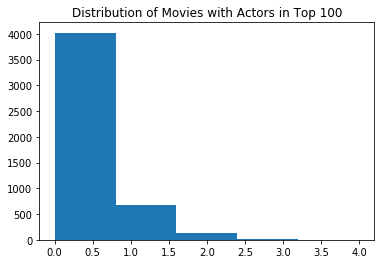

Text(0.5, 1.0, 'Distribution of Movies with Actors in Top 1000')

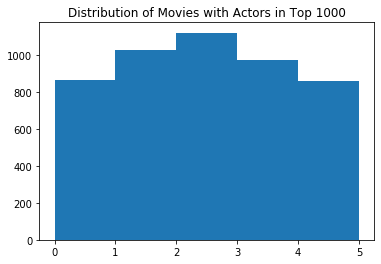

In [90]:
plt.hist(movies['top_100_actors'], bins=5)
plt.title('Distribution of Movies with Actors in Top 100')
plt.show()

plt.hist(movies['top_1000_actors'], bins=5)
plt.title('Distribution of Movies with Actors in Top 1000')

## Production Companies
I'll create a feature called 'top_pcs' which contains the number of top (most common) production companies involved in the movie.

In [91]:
# Create a list of production companies

PCs = movies.production_companies
pcs = []  # Each movie's production companies as a list, without the '|'
flatten_pcs = [] # All of the production companies as a single list

for list_of_pcs in PCs:
    movies_pcs = list_of_pcs.split('|')
    pcs.append(movies_pcs)
    for i in range(len(pcs)): #Traversing through the main list
        for j in range (len(pcs[i])): #Traversing through each sublist
            flatten_pcs.append(pcs[i][j]) #Appending elements into our flat_list
        


unique_pcs = set(flatten_pcs)
unique_pcs = list(unique_pcs)
print(len(unique_pcs))

3929


In [92]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: x.split('|'))# Making the production_companies variable into lists

In [93]:
print('First five unique production companies: ', unique_pcs[:5], '\n')
print('First five lists of production companies: ', pcs[:5], '\n')
print('First five elements of flatten_pcs: ', flatten_pcs[:5])
print('Length of flatten_pcs: ', len(flatten_pcs))

First five unique production companies:  ['Canal Plus Group', 'Glendale Picture Company', 'Burns Family Studios', 'Noodles Production', 'Concord Productions Inc.'] 

First five lists of production companies:  [['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu'], ['Village Roadshow Pictures', 'Kennedy Miller Productions'], ['Summit Entertainment', 'Mandeville Films', 'Red Wagon Entertainment', 'NeoReel'], ['Lucasfilm', 'Truenorth Productions', 'Bad Robot'], ['Universal Pictures', 'Original Film', 'Media Rights Capital', 'Dentsu', 'One Race Films']] 

First five elements of flatten_pcs:  ['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu']
Length of flatten_pcs:  33533177


In [94]:
# Production companies frequency dictionary to obtain the biggest/most common companies
pc_freqdict = {}
pcs = tuple(pcs)

for companies in pcs:
    for company in companies:
        if company in pc_freqdict:
            pc_freqdict[company] += 1
        else:
            pc_freqdict[company] = 1
    
print(type(pc_freqdict.keys()))
sorted(pc_freqdict.keys())
top_pcs = []

for key in pc_freqdict.keys():
    if pc_freqdict[key] > 14:
        top_pcs.append(key)
        
print(len(top_pcs))

<class 'dict_keys'>
97


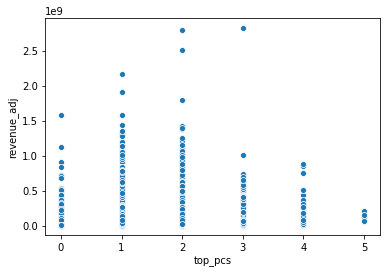

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


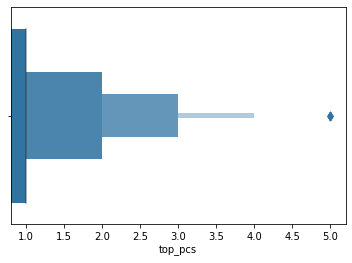

In [95]:
# Creating a new column called 'top_pcs' that will represent the number of top production companies 
# involved in a movie

movies['top_pcs'] = [len(set(i) & set(top_pcs)) for i in movies['production_companies']]
sns.scatterplot(x='top_pcs', y='revenue_adj', data=movies)
plt.show()

sns.boxenplot(x='top_pcs', data=movies)

## Book Film Adaptations
I'll import a list of books that have been adapted into movies and create a dummy variable, 'book_films', which will contain a one if the movie has been adapted from a book and a zero otherwise.

In [96]:
# Importing the book__film_adaptations 

book_film_adaptations = pd.read_csv('book_film_adaptations.csv')
book_films = pd.DataFrame(book_film_adaptations)


# Removing *s and years
book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.strip('*'))
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.replace(u'\xa0', u' ')
titles_split = book_films['Film_adaptation'].str.split('(', n=1, expand=True)
book_films['Film_adaptation'] = titles_split[0]
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.rstrip()
# book_films['Film_adaptation'] = book_films['Film_adaptation'].str.split('(')

# book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.split(' (', 1)[0])

# Converting the series to a list so we can compare it to the cast lists
book_films = book_films['Film_adaptation'].tolist()
print('\n Testing the list: ', book_films[72:77], '\n')

movies['books'] = [len(set(i) & set(book_films)) for i in movies['original_title']]
print('Number of movies adapted from books: \n', movies.books.value_counts())


 Testing the list:  ['Tom Sawyer', ' Huckleberry Finn', 'Tom Sawyer', 'The Adventures of Mark Twain', 'Back to Hannibal: The Return of Tom Sawyer and Huckleberry Finn'] 

Number of movies adapted from books: 
 0    4451
1     397
Name: books, dtype: int64


## Normalizing and Testing the Normality of the New Features¶
We can see that the T-values for the new features aren't terribly large.

In [97]:
# Normalizing new feature

movies['norm_winsorized_top_1000_actors'] = normalize(np.array(winsorize(movies['top_1000_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies['norm_winsorized_top_pcs'] = normalize(np.array(winsorize(movies['top_pcs'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)

features_to_test = ['norm_winsorized_top_1000_actors', 'top_1000_actors', 'norm_winsorized_top_pcs', 'top_pcs']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_top_1000_actors:
Jarque-Bera test statistics for norm_winsorized_top_1000_actors is 285.6854074833741 and p value is 0.0
Normality test statistics for norm_winsorized_top_1000_actors is 3726.9083415593186 and p value is 0.0

Testing for normality on top_1000_actors:
Jarque-Bera test statistics for top_1000_actors is 198.49302586769141 and p value is 0.0
Normality test statistics for top_1000_actors is 625.5989558126938 and p value is 1.4220432429128338e-136

Testing for normality on norm_winsorized_top_pcs:
Jarque-Bera test statistics for norm_winsorized_top_pcs is 212.00026473128594 and p value is 0.0
Normality test statistics for norm_winsorized_top_pcs is 1227.1251974830047 and p value is 3.413100405053702e-267

Testing for normality on top_pcs:
Jarque-Bera test statistics for top_pcs is 892.9157555077314 and p value is 0.0
Normality test statistics for top_pcs is 601.6977991126896 and p value is 2.202840416175467e-131



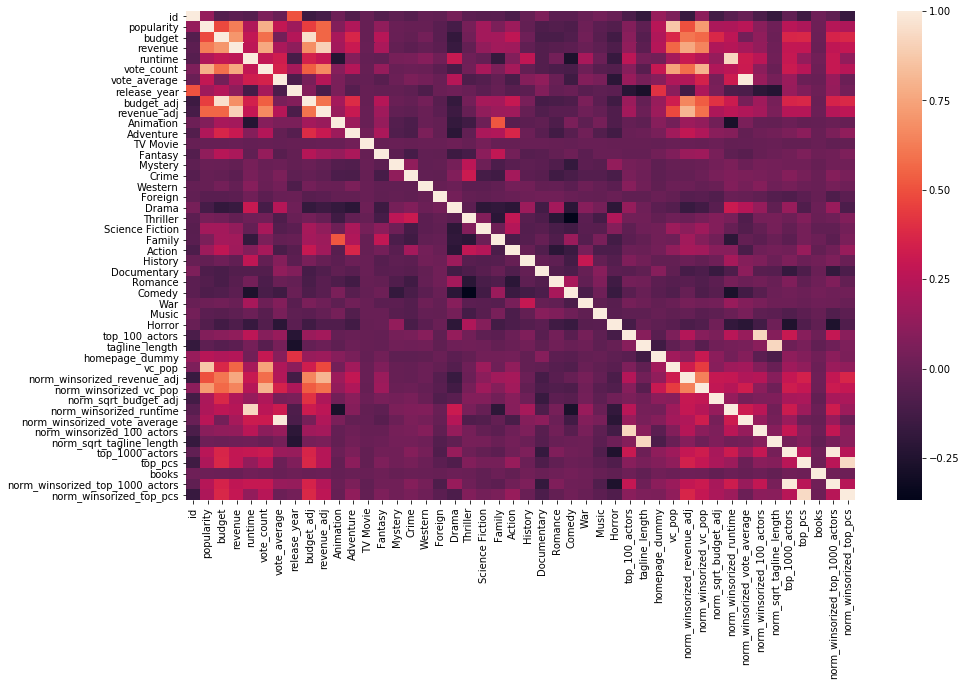

,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.761
budget_adj,0.658
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.583
popularity,0.498
norm_winsorized_top_pcs,0.365
top_pcs,0.346


In [98]:
plt.figure(figsize=(15,9))
sns.heatmap(movies.corr())
plt.show()
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)

In [99]:
print(movies.describe())

              id  popularity        budget        revenue  runtime  \
count   4848.000    4848.000      4848.000       4848.000 4848.000   
mean   44516.111       1.045  29578186.482   89231501.979  107.794   
std    72259.109       1.357  40519224.943  162096040.407   19.012   
min        5.000       0.001         0.000          2.000   15.000   
25%     8283.500       0.388   1700000.000    7724243.750   95.000   
50%    12153.500       0.681  15000000.000   31826540.000  104.000   
75%    43951.500       1.211  40000000.000   99823196.750  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  254.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  \
count    4848.000      4848.000      4848.000      4848.000       4848.000   
mean      436.324         6.148      2000.920  35092911.166  115092896.827   
std       806.560         0.799        11.571  43402495.810  198875386.412   
min        10.000         2.100      1960.000         0.0

# Round 3 - Testing Our Models With Three New Variables

In [102]:
linear_features3 = movies[['books','norm_winsorized_top_pcs','norm_winsorized_top_1000_actors', 'norm_sqrt_budget_adj',
                           'norm_winsorized_vc_pop','norm_winsorized_runtime','Adventure', 
                           'norm_winsorized_vote_average', 'Action', 'Family', 'Animation', 'Fantasy',
                           'homepage_dummy', 'Science Fiction', 'War', 'norm_sqrt_tagline_length', 'Western', 
                           'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy', 'Crime', 'Music', 
                           'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]

linear_target3 = movies['norm_winsorized_revenue_adj'] 
linear_X3_train, linear_X3_test, linear_Y3_train, linear_Y3_test = train_test_split(linear_features3, linear_target3, test_size = .3, random_state = 465)
X3_train_const = sm.add_constant(linear_X3_train)
X3_test_const = sm.add_constant(linear_X3_test)

features3 = movies[['budget_adj', 'vc_pop', 'top_pcs', 'runtime', 'top_1000_actors','Adventure', 
                    'vote_average', 'Action', 'Family', 'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction',
                    'War', 'tagline_length', 'books', 'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy',
                    'Crime', 'Music', 'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]

target3 = movies['revenue_adj'] 
X3_train, X3_test, Y3_train, Y3_test = train_test_split(features3, target3, test_size = .3, random_state = 465)


## OLS

The OLS is a fine model, but clearly the Random Forests is a higher performer with this data.

In [103]:
print("The number of observations in training set is {}".format(linear_X3_train.shape[0]))
print("The number of observations in test set is {}".format(linear_X3_test.shape[0]))

# We fit an OLS model using sklearn
linear_X3_train_const = sm.add_constant(linear_X3_train)
linear_X3_test_const = sm.add_constant(linear_X3_test)
ols = LinearRegression().fit(linear_X3_train_const, linear_Y3_train)

results_train = sm.OLS(linear_Y3_train, linear_X3_train_const).fit()
results_test = sm.OLS(linear_Y3_test, linear_X3_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y3_preds_train = ols.predict(linear_X3_train_const)
Y3_preds_test = ols.predict(linear_X3_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(linear_X3_train_const, linear_Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(linear_X3_test_const, linear_Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y3_test - Y3_preds_test) / linear_Y3_test)) * 100))

The number of observations in training set is 3393
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.578
Model:                                     OLS   Adj. R-squared:                  0.574
Method:                          Least Squares   F-statistic:                     153.6
Date:                         Sun, 15 Dec 2019   Prob (F-statistic):               0.00
Time:                                 17:16:01   Log-Likelihood:                 12022.
No. Observations:                         3393   AIC:                        -2.398e+04
Df Residuals:                             3362   BIC:                        -2.379e+04
Df Model:                                   30                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation
R-squared of 0.561, still very low MSE.

In [104]:
cross_val_scores = cross_val_score(LinearRegression(), linear_features3, linear_target3, cv=10)
nmse_cross_val_scores = cross_val_score(LinearRegression(), linear_features3, linear_target3, cv=10, scoring='neg_mean_squared_error')
print('OLS R-Squared Score: ', cross_val_scores.mean())
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n')
print('Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

OLS R-Squared Score:  0.561342189139245
R-Squared Scores with Cross Validation:  [0.61345384 0.61356388 0.66098068 0.65117429 0.60337559 0.61098962
 0.62313974 0.43718631 0.42331321 0.37624471]


Negative MSE Score:  -5.102797556034007e-05
Negative MSE Scores with Cross Validation:  [-5.19158504e-05 -4.47954158e-05 -3.77954249e-05 -4.23528534e-05
 -4.77996733e-05 -3.36160474e-05 -4.06300757e-05 -6.57553670e-05
 -6.35624817e-05 -8.20565659e-05]


## Ridge Regression with Training Sets
Similar to the two previous models, the Ridge has improved slightly.

In [105]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(linear_X3_train, linear_Y3_train)

# We are making predictions here
Y3_preds_train = ridgeregr.predict(linear_X3_train)
Y3_preds_test = ridgeregr.predict(linear_X3_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(linear_X3_train, linear_Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(linear_X3_test, linear_Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(linear_Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y3_test - Y3_preds_test) / linear_Y3_test)) * 100))

R-squared of the model on the training set is: 0.5547774648322028
-----Test set statistics-----
R-squared of the model on the test set is: 0.5385316748836355
Mean absolute error of the prediction is: 0.005492190719501939
Mean squared error of the prediction is: 5.442336678067827e-05
Root mean squared error of the prediction is: 0.007377219447778294
Mean absolute percentage error of the prediction is: 1634169.0016573123


## Ridge Regression with Cross Validation
Exact same metrics as Ridge with training/testing sets.

In [106]:
ridgeCV.fit(linear_features3, linear_target3)

# We are making predictions here
Y3_preds = ridgeCV.predict(linear_features3)


print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(ridgeCV.score(linear_features3, linear_target3)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target3, Y3_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target3, Y3_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target3, Y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target3 - Y3_preds) / linear_target3)) * 100))

-----Test set statistics-----
R-squared of the model is: 0.5568380868036497
Mean absolute error of the prediction is: 0.005358459659730738
Mean squared error of the prediction is: 5.169313311691673e-05
Root mean squared error of the prediction is: 0.007189793676936546
Mean absolute percentage error of the prediction is: 3268930.5954298447


## ElasticNet With Training/Testing Sets
This model is comparable to the OLS model.

In [107]:
# Using GridSearchCV to find the best parameters for the ElasticNEt
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.1, 0.3, 0.7, 1]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(linear_features3, linear_target3)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.1s finished


In [108]:
elasticregr = ElasticNet(l1_ratio=1, alpha=0) 
elasticregr.fit(linear_X3_train, linear_Y3_train)

# We are making predictions here
Y3_preds_train = elasticregr.predict(linear_X3_train)
Y3_preds_test = elasticregr.predict(linear_X3_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(linear_X3_train, linear_Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(linear_X3_test, linear_Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_Y3_test - Y3_preds_test) / linear_Y3_test)) * 100))

R-squared of the model on the training set is: 0.5781470418634278
-----Test set statistics-----
R-squared of the model on the test set is: 0.5638966123408689
Mean absolute error of the prediction is: 0.005208638937461088
Mean squared error of the prediction is: 5.143194739288848e-05
Root mean squared error of the prediction is: 0.007171607030009974
Mean absolute percentage error of the prediction is: 1824276.0862333388


In [109]:
elasticregrCV = ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) 
elasticregrCV.fit(linear_features3, linear_target3)

# We are making predictions here
Y3_preds = elasticregrCV.predict(linear_features3)

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(linear_features3, linear_target3)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(linear_target3, Y3_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(linear_target3, Y3_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(linear_target3, Y3_preds))))
print("Root mean squared error of the prediction is: {}".format(rmse(linear_target3, Y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((linear_target3 - Y3_preds) / linear_target3))))

-----Test set statistics-----
R-squared of the model on the test set is: 0.5122332978252231
Mean absolute error of the prediction is: 0.005710507617592449
Mean squared error of the prediction is: 5.6896110235783384e-05
Root mean squared error of the prediction is: 0.00754295102965566
Root mean squared error of the prediction is: 0.00754295102965566
Mean absolute percentage error of the prediction is: 37959.279790543114


## Random Forests
While slightly better than the last Random Forest model, I wouldn't say it's significant.

In [87]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 100, 120],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(features3, target3)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 58.6min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)


In [110]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)
rfr.fit(X3_train, Y3_train)

Y3_preds_train = rfr.predict(X3_train)
Y3_preds_test = rfr.predict(X3_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X3_train, Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X3_test, Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y3_test - Y3_preds_test) / Y3_test)) * 100))

R-squared of the model on the training set is: 0.7229419636497507
-----Test set statistics-----
R-squared of the model on the test set is: 0.5987846116908373
Mean absolute error of the prediction is: 63872585.04254679
Mean squared error of the prediction is: 1.5017237408021148e+16
Root mean squared error of the prediction is: 122544838.3573178
Mean absolute percentage error of the prediction is: 1541079.6997956403


In [111]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features3, target3, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(rfr, features3, target3, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6015860797753891
Cross Validation Scores:  [0.56852824 0.67438421 0.75066507 0.72221781 0.59956527 0.70914297
 0.700381   0.52628747 0.4880639  0.27662487]


Mean Negative MSE:  -1.6691111362191338e+16
Cross Validation MSE Scores:  [-3.39813313e+16 -8.99925885e+15 -7.54822906e+15 -1.12222937e+16
 -1.68094416e+16 -6.48626369e+15 -9.94089188e+15 -1.45153927e+16
 -1.31485618e+16 -4.42594490e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.2s finished


[2.02867309e-01 2.67302152e-01 3.62217370e-02 9.17297726e-02
 3.77025152e-02 4.62118116e-02 7.28034771e-02 1.50715448e-02
 1.74986409e-02 1.15849518e-02 1.78576797e-02 2.26570160e-02
 1.01819498e-02 1.12969978e-03 2.90569382e-02 2.09537536e-03
 4.51258418e-04 6.71107374e-03 1.29210977e-03 0.00000000e+00
 1.80120037e-03 6.91030470e-03 3.60979537e-03 1.42406750e-03
 3.65060290e-03 1.64817349e-04 4.00570308e-03 1.19910831e-03
 6.97528722e-02 1.70545159e-02]


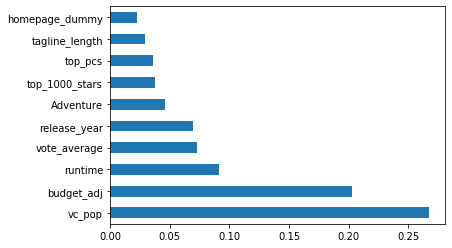

In [333]:
feat_importances = pd.Series(rfr.feature_importances_, index=features3.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Gradient Boosting
While the discrepancy between the R-squareds in the training and tests sets differ greatly, the R-squared for the test set for the Gradient Boosting model is much better than the OLS, Ride, and ElasticNet models. However, the previous set of features produced a slightly higher R-squared and lower evaluation metrics.

In [394]:

# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate': [0.001, 0.01, 0.1, 1],
            'n_estimators': [800, 1000, 1500, 2000],
            'max_depth': [3, 4, 5]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features3, target3)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], 
                    max_depth=best_params['max_depth'],  tol=0.001)
print('Best parameters for Gradient Boosting Model: ', best_gbr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 35.2min finished


Best parameters for Gradient Boosting Model:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [112]:
# fitting the model with the best parameters
best_gbr.fit(features3, target3)

Y3_preds_train = best_gbr.predict(X3_train)
Y3_preds_test = best_gbr.predict(X3_test)

print("R-squared of the model on the training set is: {}".format(best_gbr.score(X3_train, Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(best_gbr.score(X3_test, Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y3_test - Y3_preds_test) / Y3_test)) * 100))

R-squared of the model on the training set is: 0.8822659279465277
-----Test set statistics-----
R-squared of the model on the test set is: 0.828860192494301
Mean absolute error of the prediction is: 44114802.080460295
Mean squared error of the prediction is: 6405654404500887.0
Root mean squared error of the prediction is: 80035332.2258419
Mean absolute percentage error of the prediction is: 829777.4869038394


In [113]:
cross_val_scores = cross_val_score(best_gbr, features3, target3, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(best_gbr, features3, target3, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.659201322459189
Cross Validation Scores:  [0.65633844 0.64973608 0.78028776 0.73427187 0.69872312 0.74543842
 0.79176198 0.60108208 0.56405663 0.37031685]


Mean Negative MSE:  -1.416043004967232e+16
Cross Validation MSE Scores:  [-2.73956977e+16 -9.70965684e+15 -6.74109505e+15 -1.08040530e+16
 -1.27667519e+16 -5.69363510e+15 -6.88861781e+15 -1.21471183e+16
 -1.13447565e+16 -3.81129182e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


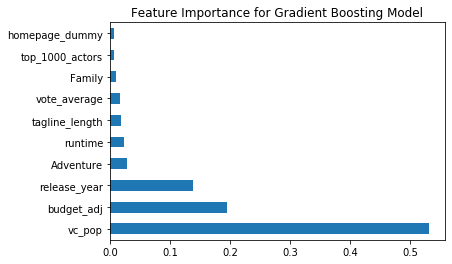

In [114]:
feat_importances = pd.Series(best_gbr.feature_importances_, index=features3.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance for Gradient Boosting Model')
plt.show()

## XGBoost with Training & Testing Sets

In [207]:
gbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
     'colsample_bytree': np.linspace(0.3, 0.5, 0.9),
     'n_estimators': [25, 50, 100],
     'max_depth': [5, 10, 20],
    'objective' : ['reg:squarederror']
}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 10, verbose = 1)

grid_mse.fit(X3_train, Y3_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest MSE found: ", np.abs3grid_mse.best_score_)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 9000 out of 9000 | elapsed: 557.0min finished


Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'objective': 'reg:squarederror'}
Lowest MSE found:  1.6500402028813206e+16


In [116]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, n_estimators=100)

xg.fit(X3_train, Y3_train)
Y3_preds_train = xg.predict(X3_train)
Y3_preds_test = xg.predict(X3_test)

print("MSE of train set: %f" % (mean_squared_error(Y3_train, Y3_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y3_test, Y3_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X3_train, Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X3_test, Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y3_test, Y3_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y3_test - Y3_preds_test) / Y3_test)) * 100))

MSE of train set: 3071585572767815.000000
MSE of test set: 12501814928838136.000000
R-squared of the model on the training set is: 0.9240596502734838
-----Test set statistics-----
R-squared of the model on the test set is: 0.6659891300270762
Mean absolute error of the prediction is: 56138105.25187997
Mean squared error of the prediction is: 1.2501814928838136e+16
Root mean squared error of the prediction is: 111811515.18890233
Mean absolute percentage error of the prediction is: 858554.1643140848


In [117]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, n_estimators=100)

xg.fit(features3,target3)
cross_val_scores = cross_val_score(xg, features3, target3, cv=10)
nmse_cross_val_scores = cross_val_score(xg, features3, target3, cv=10, scoring='neg_mean_squared_error')
print('XGBoost Score: ', xg.score(features3, target3))
print('XGBoost mean of R-squared array: ', cross_val_scores.mean())
print('XGBoost R-squared array: ', cross_val_scores)
print('XGBoost Mean MSE: ', nmse_cross_val_score.mean())
print('XGBoost Negative MSE array: ', cross_val_score(xg, features3, target3, cv=10, scoring='neg_mean_squared_error'))


XGBoost Score:  0.8992315671293352
XGBoost mean of R-squared array:  0.6556405356310119
XGBoost R-squared array:  [0.64554594 0.62528177 0.79187921 0.75385179 0.71788052 0.71598573
 0.76819822 0.61246905 0.57477832 0.35053481]
XGBoost Mean MSE:  -1.416043004967232e+16
XGBoost Negative MSE array:  [-2.82638019e+16 -1.03488412e+16 -6.32094832e+15 -9.90989916e+15
 -1.20294353e+16 -6.39551126e+15 -7.65291184e+15 -1.17978876e+16
 -1.09646298e+16 -3.91263542e+16]


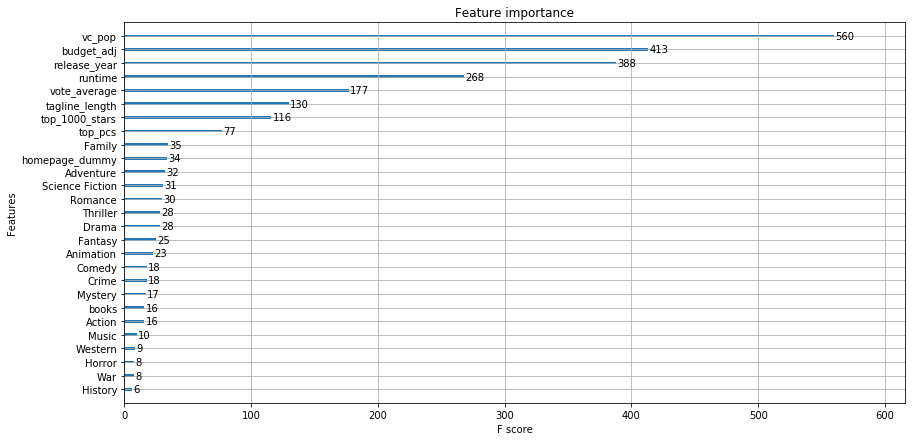

In [341]:
xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = (17,7)

## Summary of Third Round 

|Model | R-Squared Value |Mean Squared Error
------|------|------|
|OLS (Test) |0.647 | 4.2370e-05
|OLS (CV) |0.562 | 5.0968e-05
|Ridge Regression (Test) |0.539 |5.4338e-05
|Ridge Regression (CV) |0.557 |5.1629e-05
|ElasticNet (Test) |0.564 |5.1359e-05
|ElasticNet (CV) |0.512 |5.6882e-05
|Random Forests (Test) |0.602 | 1.4872e+16
|Random Forests (CV) |0.601 | 1.6680e+16
|Gradient Boosting (Test)|0.783| 8.1032e+15
|Gradient Boosting (CV)|0.656| 1.4361e+16
|XGBoost (Test)|0.665| 1.2501e+16
|XGBoost (CV)|0.655| 1.4100e+16

# Round Four - Using Feature Importance

In [118]:
OLS_features = movies[['norm_sqrt_budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_top_pcs', 
                       'norm_winsorized_runtime', 'norm_winsorized_top_1000_actors','Adventure', 
                       'norm_winsorized_vote_average', 'Action', 'Family', 'Animation', 'Fantasy',
                       'homepage_dummy', 'Science Fiction', 'War', 'norm_sqrt_tagline_length', 'books', 
                       'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy', 'Crime', 'Music',
                       'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]

linear_target = movies['norm_winsorized_revenue_adj'] 
OLS_X_train, OLS_X_test, OLS_Y_train, OLS_Y_test = train_test_split(OLS_features, linear_target, test_size = .3, random_state = 465)
OLS_train_const = sm.add_constant(OLS_X_train)
OLS_test_const = sm.add_constant(OLS_X_test)

print("The number of observations in training set is {}".format(OLS_X_train.shape[0]))
print("The number of observations in test set is {}".format(OLS_X_test.shape[0]))

# We fit an OLS model using sklearn
OLS_X_train_const = sm.add_constant(OLS_X_train)
OLS_X_test_const = sm.add_constant(OLS_X_test)
ols = LinearRegression().fit(OLS_X_train_const, OLS_Y_train)

results_train = sm.OLS(OLS_Y_train, OLS_X_train_const).fit()
results_test = sm.OLS(OLS_Y_test, OLS_X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y_preds_train = ols.predict(OLS_X_train_const)
Y_preds_test = ols.predict(OLS_X_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(OLS_X_train_const, OLS_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(OLS_X_test_const, OLS_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(OLS_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(OLS_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(OLS_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((OLS_Y_test - Y_preds_test) / OLS_Y_test)) * 100))


KeyError: "['norm_winsorized_top_1000_stars'] not in index"

## Random Forests

In [384]:
rfr_features = movies[['vc_pop', 'budget_adj', 'runtime', 'vote_average', 'release_year',  
                      'Adventure', 'top_1000_actors', 'top_pcs', 'tagline_length', 'homepage_dummy']]

target = movies['revenue_adj'] 
rfr_X_train, rfr_X_test, rfr_Y_train, rfr_Y_test = train_test_split(xg_features, target, test_size = .3, random_state = 465)



rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)
rfr.fit(rfr_X_train, rfr_Y_train)

Y_preds_train = rfr.predict(rfr_X_train)
Y_preds_test = rfr.predict(rfr_X_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(rfr_X_train, rfr_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(rfr_X_test, rfr_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(rfr_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(rfr_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(rfr_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((rfr_Y_test - Y_preds_test) / rfr_Y_test)) * 100))

R-squared of the model on the training set is: 0.8178418556281883
-----Test set statistics-----
R-squared of the model on the test set is: 0.6514432700715858
Mean absolute error of the prediction is: 56926396.20459221
Mean squared error of the prediction is: 1.30462572374345e+16
Root mean squared error of the prediction is: 114220213.78650323
Mean absolute percentage error of the prediction is: 815407.6435107278


In [385]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, rfr_features, target, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(rfr, rfr_features, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   55.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.65540274075592
Cross Validation Scores:  [0.62411931 0.67640441 0.77659275 0.76982737 0.67321075 0.74566144
 0.74676888 0.61440942 0.58000408 0.34702901]


Mean Negative MSE:  -1.443395006687078e+16
Cross Validation MSE Scores:  [-2.99044346e+16 -8.79063223e+15 -6.73732765e+15 -9.19694849e+15
 -1.39617131e+16 -5.70220863e+15 -8.33537447e+15 -1.17838576e+16
 -1.09317298e+16 -3.89952742e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   54.3s finished


## Gradient Boosting Regression

In [389]:
gbr_features = movies[['vc_pop', 'budget_adj', 'release_year']]

target = movies['revenue_adj'] 
gbr_X_train, gbr_X_test, gbr_Y_train, gbr_Y_test = train_test_split(gbr_features, target, test_size = .3, random_state = 465)

best_gbr.fit(movies[['vc_pop', 'budget_adj', 'release_year']], target)

Y_preds_train = best_gbr.predict(X4_train)
Y_preds_test = best_gbr.predict(X4_test)

print("R-squared of the model on the training set is: {}".format(best_gbr.score(gbr_X_train, gbr_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(best_gbr.score(gbr_X_test, gbr_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(gbr_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(gbr_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(gbr_Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((gbr_Y_test - Y_preds_test) / gbr_Y_test)) * 100))

R-squared of the model on the training set is: 0.8316779269639081
-----Test set statistics-----
R-squared of the model on the test set is: 0.779277702405924
Mean absolute error of the prediction is: 149498463.06669062
Mean squared error of the prediction is: 6.49395664251984e+16
Root mean squared error of the prediction is: 254832428.12718794
Mean absolute percentage error of the prediction is: 7026553.974335346


In [358]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

cross_val_scores = cross_val_score(gbr, gbr_features, target, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(gbr, gbr_features, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6070567552098827
Cross Validation Scores:  [0.61906029 0.5804173  0.70285738 0.64015145 0.70902893 0.74027838
 0.678841   0.5537033  0.46275278 0.38347673]


Mean Negative MSE:  -1.5887027983179052e+16
Cross Validation MSE Scores:  [-3.04737816e+16 -1.14550385e+16 -9.06075187e+15 -1.43834002e+16
 -1.24506815e+16 -5.83560627e+15 -1.05280661e+16 -1.35961471e+16
 -1.38119745e+16 -3.72748322e+16]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


## XGBoost

In [390]:
xg_features = movies[['vc_pop', 'budget_adj', 'release_year', 'runtime', 'vote_average', 
                      'tagline_length', 'top_1000_actors', 'top_pcs', 'Family']]

target = movies['revenue_adj'] 
xg_X_train, xg_X_test, xg_Y_train, xg_Y_test = train_test_split(xg_features, target, test_size = .3, random_state = 465)


xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.3,
                max_depth = 10, n_estimators=50)

xg.fit(xg_X_train, xg_Y_train)
Y_preds_train = xg.predict(xg_X_train)
Y_preds_test = xg.predict(xg_X_test)

print("MSE of train set: %f" % (mean_squared_error(xg_Y_train, Y_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(xg_Y_test, Y_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(xg_X_train, xg_Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(xg_X_test, xg_Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(xg_Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(xg_Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(xg_Y_test, Y_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((xg_Y_test - Y_preds_test) / xg_Y_test)) * 100))

MSE of train set: 38834952402823.632812
MSE of test set: 14288525020882608.000000
R-squared of the model on the training set is: 0.9990398640059943
-----Test set statistics-----
R-squared of the model on the test set is: 0.6182536135736552
Mean absolute error of the prediction is: 60220216.514537714
Mean squared error of the prediction is: 1.4288525020882608e+16
Root mean squared error of the prediction is: 119534618.50394055
Mean absolute percentage error of the prediction is: 750348.4375336181


In [393]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, n_estimators=100)

xg.fit(xg_features,target)
cross_val_scores = cross_val_score(xg, xg_features, target, cv=10)
nmse_cross_val_scores = cross_val_score(xg, xg_features, target, cv=10, scoring='neg_mean_squared_error')
print('XGBoost Score: ', xg.score(xg_features, target))
print('XGBoost mean of R-squared array: ', cross_val_scores.mean())
print('XGBoost R-squared array: ', cross_val_scores)
print('XGBoost Mean MSE: ', nmse_cross_val_score.mean())
print('XGBoost Negative MSE array: ', cross_val_score(xg, xg_features, target, cv=10, scoring='neg_mean_squared_error'))


XGBoost Score:  0.8859605159466831
XGBoost mean of R-squared array:  0.6394417339119021
XGBoost R-squared array:  [0.62857768 0.55823821 0.74931441 0.76127088 0.74633401 0.73366658
 0.74658454 0.57293869 0.55062591 0.34686642]
XGBoost Mean MSE:  -1.443395006687078e+16
XGBoost Negative MSE array:  [-2.96168336e+16 -1.22004275e+16 -7.61370648e+15 -9.61120744e+15
 -1.08161924e+16 -5.99736903e+15 -8.36648520e+15 -1.30013392e+16
 -1.15874161e+16 -3.93473525e+16]


## Summary
To recall, the goal of this project was to predict the adjusted revenue of a movie given the dataset I had. While I started with nearly 11,000 movies, I immediately had to cut 6,000 as they did not have information for the target variable. I cleaned the data, transformed the features for the linear regression models, and ran seven different types of models on the data using four different sets of features.

# Conclusions

While all the linear regression models had low MSEs throughout testing, the OLS model had the lowest in the second and third rounds. This indicates that the OLS model was closest to the actual data points. The Gradient Boosting model consistently provided the highest R-squared values meaning it was able to account for more of the variance, but the simultaneously high MSEs show it's a bad fit, along with the other non-linear regression models.

# Further Investigation

I'd be interested to analyze this dateset with the following information to see if I can increase the performance of the model:

- Budget breakdown (specifically Marketing/commercial budget)
- Month of release
- Theatres vs. straight to DVD vs. Netflix
- Cast diversity